In [2]:
import glob

import bottleneck as bn
import matplotlib
import matplotlib.dates as mdate
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import pywt
import scipy.signal
import ssqueezepy

In [3]:
"""
Rule of thumb for the shape of numpy.ndarray: Frequency Dimension (Nf) -> Time Dimension (Nt) -> Component Dimension (3, or 3 x 3 / 6 x 3 for spectral maxtrix)
"""

def wavelet_coef_psd(time: np.ndarray, signal: np.ndarray, scales: np.ndarray, bandwidth: float = 6.0, downsample: int = 1, downsample_signal: bool = True):
    """
    Compute complex Morlet wavelet coefficients and power spectral density (PSD).
    Complex Morlet wavelet can be written as:

    Parameters:
    ----------
    time : np.ndarray
        Time vector of shape (Nt,). Can be in seconds or `np.datetime64`.
    signal : np.ndarray
        Input signal of shape (Nt,).
    scales : np.ndarray
        Wavelet scales corresponding to frequencies of shape (Nf,).
    bandwidth : float, optional
        bandwidthandwidth parameter for the Morlet wavelet (default is 6.0).
    downsample : int, optional
        Downsampling factor for the output (default is 1, meaning no downsampling).
    downsample_signal : bool, optional
        If True, downsample the input signal before computing wavelet coefficients (default is False).
        If False, the signal is not downsampled, but the output coefficients and PSD are downsampled.

    Returns:
    -------
    time : np.ndarray
        Time vector after optional downsampling.
    frequency : np.ndarray
        Frequencies corresponding to the wavelet scales.
    coef : np.ndarray
        Complex wavelet coefficients of shape (Nf, Nt), where Nf is the number of frequencies.
    psd : np.ndarray
        Power spectral density of shape (Nf, Nt).
    signal : np.ndarray
        Downsampled (moving average) signal if downsampling is applied.

    Notes:
    -----
    - The function uses `scipy.signal.cwt` with the Morlet wavelet by default.
    - `scipy.signal.cwt` is deprecated in SciPy 1.12 and will be removed in SciPy 1.15. Alternatives like PyWavelets or ssqueezepy can be used.
    - The power spectral density (PSD) is computed as the squared magnitude of the wavelet coefficients, scaled by `2 * dt`.
    - Downsampling is applied to the time, coefficients, PSD, and signal if `downsample > 1`.
    """

    if downsample_signal:
        time = time[::downsample]
        signal = signal[::downsample]
        downsample = 1

    if isinstance(time[0], np.datetime64):
        elapsed_time = np.array(time).astype('datetime64[ns]').astype('float') / 1e9
    else:
        elapsed_time = np.array(time)

    dt = elapsed_time[1] - elapsed_time[0]

    # === Option 1: scipy.signal implementation ===
    # bandwidthut, scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed in SciPy 1.15. 
    # They recommend using PyWavelets instead.
    # https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.signal.cwt.html
    # However, as you can see in the bottom code block, pywt.cwt is actually problematic for the Morlet wavelet.

    # widths = bandwidth * scales / (2 * np.pi)
    # coef = scipy.signal.cwt(
    #     signal,
    #     scipy.signal.morlet2,
    #     widths = widths,
    #     w = bandwidth,
    #     dtype = np.complex128
    # )
    # frequency = 1 / dt / scales

    # === Option 2: pywt implementation ===
    # Unlike scipy.signal.cwt, pywt.cwt is not L2-normalized.
    # You need to multiply the coefficients by a factor to make them L2-normalized.
    # Another two problems with pywt.cwt: The precision of the wavelet may be unenough while you can still not adjust the precision yourself.
    # Check https://github.com/PyWavelets/pywt/issues/531
    # This defect has been proposed at 2019 but still not fixed yet.

    # central_frequency = 1.0
    # wavelet = 'cmor%.1f-%.1f' % (bandwidth, central_frequency)
    # coef, frequency = pywt.cwt(signal, scales, wavelet, dt, method = 'fft')
    # coef *= np.sqrt(np.sqrt(bandwidth) * np.sqrt(2 * np.pi))  # amplitude normalization for Morlet

    # === Option 3: ssqueezepy implementation (default used here) ===
    # This one is accurate and fast. They claim that this package is the fastest implementation of the wavelet transform in Python.
    # bandwidthut, this implementation is not elegantly designed and the input parameters are not well documented.
    # Also, it requires package numba, which may raise some compatibility issues.
    coef, scales = ssqueezepy.cwt(signal, ('morlet', {'mu': bandwidth}), scales = bandwidth / (2 * np.pi) * scales.astype(np.float32), fs = 1 / dt, l1_norm = False)
    frequency = bandwidth / (2 * np.pi) / dt / scales

    # coef, _, frequency, _ = ssqueezepy.ssq_cwt(signal, ('morlet', {'mu': bandwidth}), scales = bandwidth / (2 * np.pi) * scales.astype(np.float32), fs = 1 / dt)
    # coef = (coef.T * bandwidth * np.sqrt(scales / np.pi)).T

    psd = (np.abs(coef) ** 2) * (2 * dt)
    
    return time[::downsample], frequency, coef[:, ::downsample], psd[:, ::downsample], signal[::downsample]

def wfft_coef_psd(time: np.ndarray, signal: np.ndarray, step: int = 1, window: int = 120):
    """
    Compute short-time Fourier transform (STFT) coefficients and power spectral density (PSD) using a sliding Hanning window.

    Parameters:
    ----------
    time : np.ndarray
        Time vector of shape (Nt,). Can be in seconds or `np.datetime64`.
    signal : np.ndarray
        Input signal of shape (Nt,).
    step : int, optional
        Step size for sliding the window (default is 1).
    window : int, optional
        Window length in samples (default is 120).

    Returns:
    -------
    wtime : np.ndarray
        Center time for each window after sliding.
    freq : np.ndarray
        Frequency vector corresponding to the FFT.
    coef : np.ndarray
        Complex FFT coefficients of shape (Nf, Nt), where Nf is the number of frequencies.
    psd : np.ndarray
        Power spectral density of shape (Nf, Nt).
    wsignal : np.ndarray
        Window-averaged signal of shape (Nt,).

    Notes:
    -----
    - The Hanning window is applied to each segment, and normalization is performed based on Parseval's theorem.
    - The PSD is computed as the squared magnitude of the FFT coefficients, scaled by `2 * dt / window`.
    """

    if isinstance(time[0], np.datetime64):
        elapsed_time = np.array(time).astype('datetime64[ns]').astype('float') / 1e9
    else:
        elapsed_time = np.array(time)

    dt = elapsed_time[1] - elapsed_time[0]

    # Apply sliding window view
    wtime = np.lib.stride_tricks.sliding_window_view(elapsed_time, window)[::step][:, 0] + dt * window / 2
    freq = np.fft.fftfreq(window, dt)[:window // 2]
    freq = np.fft.rfftfreq(window, dt)
    freq = np.abs(freq)
    wsignal = np.lib.stride_tricks.sliding_window_view(signal, window)[::step]
    wsignal = wsignal - np.nanmean(wsignal, axis=-1, keepdims=True)  # Remove mean to avoid DC component
    # Apply Hanning window and normalize based on Parseval's theorem
    wsignal = wsignal * np.sqrt(8 / 3) * np.hanning(window)

    coef = np.fft.fft(wsignal, axis=-1)[:, :window // 2].T
    coef = np.fft.rfft(wsignal, axis=-1).T


    psd = (np.abs(coef) ** 2) * dt / window
    
    # Double the PSD values except for the DC component and Nyquist frequency
    if window % 2 == 0:
        psd[1:-1] *= 2

    else:
        psd[1:] *= 2

    if isinstance(time[0], np.datetime64):
        wtime = (np.array(wtime) * 1e9).astype('datetime64[ns]')

    wsignal = np.mean(wsignal, axis=-1)

    return wtime, freq, coef, psd, wsignal


def svd_wave_analysis(coef: np.ndarray, freq_window: int = 5, time_window: int = 5):
    """
    Perform SVD-based wave polarization analysis to compute planarity, ellipticity, and coherence.

    Parameters:
    ----------
    coef : np.ndarray
        Complex coefficient tensor of shape (Nf, Nt, 3), where Nf is the number of frequencies, Nt is the number of time points, and 3 represents the 3 components.
    freq_window : int, optional
        Frequency-domain smoothing window size (default is 5).
    time_window : int, optional
        Time-domain smoothing window size (default is 5).

    Returns:
    -------
    planarity : np.ndarray
        Planarity of the wave of shape (Nf, Nt), defined as `1 - sqrt(s3 / s1)`, where s1 and s3 are the largest and smallest singular values.
    ellipticity_along_k: np.ndarray
        Ellipticity along the wave vector direction of shape (Nf, Nt), defined as the ratio of the second to the first singular value.
    coherence : np.ndarray
        Coherence between the first and second principal components (along vh1 and vh2) of shape (Nf, Nt), computed from the smoothed wavefield spectrum.
    degree_of_polarization : np.ndarray
        3D Degree of polarization of shape (Nf, Nt), defined as `sqrt[3 / 2 * tr(J^2) / tr^2(J) - 1 / 2]`, computed using the wavefield spectrum.
    vh : np.ndarray
        Right singular vectors of shape (Nf, Nt, 3, 3), representing the polarization basis.

    Notes:
    -----
    - The input coefficients are smoothed in both frequency and time domains before performing SVD.
    - The coherence is computed from the wavefield spectrum in the transformed basis.
    """

    spec = np.einsum('fti,ftj->ftij', coef, coef.conj())
    spec = bn.move_mean(spec, window=freq_window, min_count=1, axis=0)
    spec = bn.move_mean(spec, window=time_window, min_count=1, axis=1)

    spec_63 = np.concatenate([spec.real, spec.imag], axis=-2)
    u, s, vh = np.linalg.svd(spec_63, full_matrices=False)

    planarity = 1 - np.sqrt(s[:, :, 2] / s[:, :, 0])
    ellipticity_along_k = s[:, :, 1] / s[:, :, 0]

    # ellipticity_along_k = (s[:, :, 1] - s[:, :, 2]) / (s[:, :, 0] - s[:, :, 2])

    # Rotate the coefficients to the wave frame, in which the third component is the least significant
    coef_wf = np.einsum('ijk,ijlk->ijl', coef, vh)
    spec_wf = np.einsum('ijk,ijl->ijkl', coef_wf, coef_wf.conj())
    spec_wf = bn.move_mean(spec_wf, window=freq_window, min_count=1, axis=0)
    spec_wf = bn.move_mean(spec_wf, window=time_window, min_count=1, axis=1)

    # There are two ways to compute the degree of polarization:
    # To see the difference in theory, please refer to the paper by Taubenschuss and Santonlik (2019).
    # Equation (28) in Taubenschuss and Santonlik 2019: 
    # degree_of_polarization = np.sqrt(3 / 2 * np.abs(np.trace(np.matmul(spec, spec), axis1 = 2, axis2 = 3) / (np.trace(spec, axis1 = 2, axis2 = 3) ** 2)) - 1 / 2)

    # Equation (74) in Taubenschuss and Santonlik 2019:
    # Be careful about np.linalg.eigh, which returns the eigenvalues in ascending order
    # While np.linalg.svd returns the singular values in descending order  
    w, v = np.linalg.eigh(spec)
    degree_of_polarization = (w[:, :, 2] - w[:, :, 1]) / np.sum(w, axis = -1)

    coherence = np.abs(spec_wf[:, :, 0, 1]) / np.sqrt(np.abs(spec_wf[:, :, 0, 0] * spec_wf[:, :, 1, 1]))

    # eigenvalues, _ = np.linalg.eig(spec_wf[:, :, :2, :2])
    # eigenvalues_r, _ = np.linalg.eig(spec_wf[:, :, :2, :2].real)
    # ellipticity_along_k = np.sqrt((np.min(eigenvalues_r[:, :, :].real, axis = -1) - np.min(eigenvalues[:, :, :].real, axis = -1)) \
    #                               / (np.max(eigenvalues_r[:, :, :].real, axis = -1) - np.min(eigenvalues[:, :, :].real, axis = -1)))

    eigenvalues_r, _ = np.linalg.eigh(spec_wf[:, :, :2, :2].real) # Ascending
    eigenvalues, _ = np.linalg.eigh(spec_wf[:, :, :2, :2]) # Ascending

    ellipticity_along_k = np.sqrt((eigenvalues_r[:, :, 0] - eigenvalues[:, :, 0]) \
                                  / (eigenvalues_r[:, :, 1] - eigenvalues[:, :, 0]))

    return planarity, ellipticity_along_k, coherence, degree_of_polarization, vh


def fac_wave_analysis(coef: np.ndarray, magf: np.ndarray):
    """
    Project wave coefficients into the field-aligned coordinate (FAC) system.

    Parameters:
    ----------
    coef : np.ndarray
        Wavelet or FFT coefficient tensor of shape (Nf, Nt, 3), where Nf is the number of frequencies, Nt is the number of time points, and 3 represents the 3 components.
    field : np.ndarray
        Reference magnetic field vector of shape (Nt, 3).

    Returns:
    -------
    compressibility : np.ndarray
        Ratio of parallel power to the total power, indicating the compressibility of the wave.
    ellipticity_along_b : np.ndarray
        Ellipticity along the magnetic field direction, defined as the ratio of left-hand to right-hand polarized power.

    Notes:
    -----
    - The FAC system is defined using the magnetic field vector as the parallel direction, and two perpendicular directions are computed using cross products.
    - The left-hand and right-hand polarized components are computed in the perpendicular plane.
    """
    dir_para = (magf.T / np.linalg.norm(magf, axis = 1)).T
    # Find the reference direction that is furthest from the magnetic field direction
    dir_ref = np.eye(3)[np.argmin(np.abs(dir_para), axis = 1)]

    dir_perp_1 = np.cross(dir_para, dir_ref)
    dir_perp_1 = (dir_perp_1.T / np.linalg.norm(dir_perp_1, axis = 1)).T

    dir_perp_2 = np.cross(dir_para, dir_perp_1)
    dir_perp_2 = (dir_perp_2.T / np.linalg.norm(dir_perp_2, axis = 1)).T

    coef_para = np.einsum('ijk,jk->ij', coef, dir_para)
    coef_perp1 = np.einsum('ijk,jk->ij', coef, dir_perp_1)
    coef_perp2 = np.einsum('ijk,jk->ij', coef, dir_perp_2)

    coef_lh = (coef_perp1 - 1j * coef_perp2) / np.sqrt(2)
    coef_rh = (coef_perp1 + 1j * coef_perp2) / np.sqrt(2)

    ellipticity_along_b = (np.abs(coef_rh) - np.abs(coef_lh)) / (np.abs(coef_rh) + np.abs(coef_lh))
    compressibility = np.abs(coef_para) ** 2 / (np.abs(coef_para) ** 2 + np.abs(coef_lh) ** 2 + np.abs(coef_rh) ** 2)

    return compressibility, ellipticity_along_b


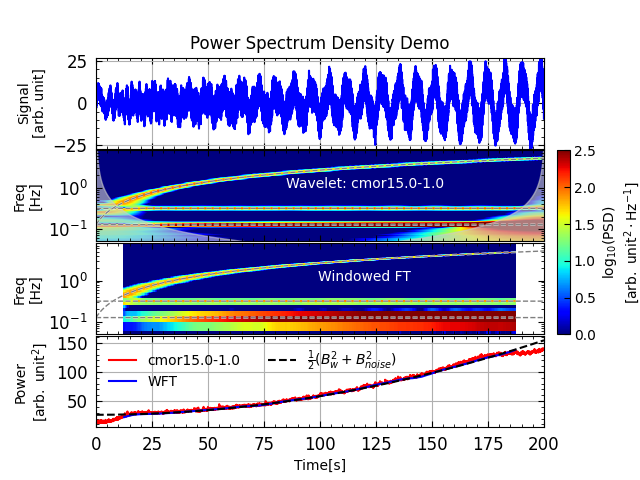

In [4]:
%matplotlib ipympl
plt.close()

bandwidth = 15.0
central_frequency = 1.0

wavelet = 'cmor%.1f-%.1f' % (bandwidth, central_frequency)

scales = np.power(2, np.linspace(1, 13, 260 + 1))

# Scales are the frequency range of the wavelet, the larger the scale, the lower the frequency.
# A scale of 2^0 = 1 will be the highest frequency [Sampling Frequency]
# A scale of 2^1 = 2 corresponds to the Nyquist frequency [Sampling Frequency / 2]
# So, do not use a scale less than 2.0 eventhough the cwt function can accept it
# Especially when use scipy.signal.cwt

plt.subplots_adjust(hspace = 0.02, right = 0.85, left = 0.15)

ax1 = plt.subplot(4, 1, 1)
ax2 = plt.subplot(4, 1, 2, sharex = ax1)
ax3 = plt.subplot(4, 1, 3, sharex = ax1, sharey = ax2)
ax4 = plt.subplot(4, 1, 4, sharex = ax1)

N = int(2 ** 15)

t = np.linspace(0, 200, N)
dt = t[1] - t[0]
fs = 1 / dt

omega = 0.4

# Generate a signal with 4 components: 
# 1. Sinuoidal; 2. Growing Sinuoidal; 3. Chirping Sinuoidal; 4. White noise

sig = 3 * np.sin(5 * omega * t) + 8 * t / 100 * np.sin(2 * omega * t) + 6 * np.sin(2 * omega * (t + 10) * t / 10)

for ax in [ax2, ax3]:
    _linestyle  = {'linestyle': '--', 'linewidth' : 1.0, 'alpha': 0.5, 'color': 'k', 'path_effects' : [pe.withStroke(linewidth=1.5, foreground="w")]}
    ax.plot(t, np.ones_like(t) * 2 * omega / (2 * np.pi), **_linestyle)
    ax.plot(t, np.ones_like(t) * 5 * omega / (2 * np.pi), **_linestyle)
    ax.plot(t, np.ones_like(t) * 2 * omega * (2 * t + 10) / 10 / (2 * np.pi), **_linestyle)
    ax.plot(t, np.ones_like(t) / dt / 2, **_linestyle)

noise_level = 2
sig += np.random.randn(N) * noise_level

ax1.plot(t, sig, 'b')
ax1.set_ylim(-27, 27)

# _, frequencies, wavelet_psd = wavelet_psd(t, sig, scales)
wavelet_time, wavelet_frequency, wavelet_coef, wavelet_psd, wavelet_avg = wavelet_coef_psd(t, sig, scales, bandwidth = bandwidth, downsample = 1)

pc2 = ax2.pcolormesh(wavelet_time, wavelet_frequency, np.log10(wavelet_psd.T + 1e-9).T, cmap='jet', vmax=2.5, vmin=0.0)
ax2.set_ylim(0.05, 8)
ax2.set_yscale('log')

wavelet_coi = (np.sqrt(2) * bandwidth / (2 * np.pi) / wavelet_frequency).astype(dt.dtype)

ax2.fill_betweenx(wavelet_frequency, x1 = t[0], x2 = t[0] + wavelet_coi, alpha = 0.6, color = '#CCCCCC', hatch = None)
ax2.fill_betweenx(wavelet_frequency, x1 = t[-1], x2 = t[-1] - wavelet_coi, alpha = 0.6, color = '#CCCCCC', hatch = None)

df = (wavelet_frequency[0] / wavelet_frequency[1] - 1) * wavelet_frequency / np.sqrt(wavelet_frequency[0] / wavelet_frequency[1])
# Numerical integration of the PSD to get the wave power
integrated_wavelet_psd = np.sum((wavelet_psd.T) * df, axis = 1)
ax4.plot(wavelet_time, integrated_wavelet_psd, 'r', label = wavelet)

step = 100
window = 4096
# windowed_time, windowed_frequency, psd_matrix = windowed_fft_psd(t,sig,step,window)
wfft_time, wfft_frequency, wfft_coef, wfft_psd, wfft_avg = wfft_coef_psd(t, sig, step,window)

pc3 = ax3.pcolormesh(wfft_time, wfft_frequency, np.log10(wfft_psd), cmap='jet', vmax=2.5, vmin=0.0)

df = np.diff(wfft_frequency)[0]
integrated_wfft_psd = np.nansum((wfft_psd.T * df), axis=1)
ax4.plot(wfft_time, integrated_wfft_psd, 'b', label='WFT')

# Theoretical PSD defined as half of the sum of the square of amplitudes of the components
ax4.plot(t, np.ones_like(t) * (3 ** 2 + (8 * t / 100) ** 2 + 6 ** 2 + 2 * noise_level ** 2) / 2, 'k--', label=r'$\frac{1}{2}{(B_w^2 + B_{noise}^2)}$')


fig = plt.gcf()
cbar_ax2 = fig.add_axes(
    [ax2.get_position().x1 + 0.02, ax3.get_position().y0, 0.02, ax2.get_position().y1 - ax3.get_position().y0])
cbar2 = plt.colorbar(pc2, cax=cbar_ax2)
cbar2.ax.xaxis.set_label_position('top')
cbar2.ax.xaxis.set_ticks_position('top')
cbar2.ax.tick_params(which='major', length=4, direction='in', pad=3)
cbar2.ax.set_ylabel('$\mathrm{log_{10}(PSD)}$\n$\mathrm{[arb.\ unit^2 \cdot Hz^{-1}]}$')

ax1.grid('on')
ax4.grid('on')
ax4.legend(frameon=False, ncols = 2)

ax4.set_xlabel('Time[s]')
ax1.set_ylabel('Signal\n[arb. unit]')
ax2.set_ylabel('Freq\n[Hz]')
ax3.set_ylabel('Freq\n[Hz]')
ax4.set_ylabel('Power\n[$\mathrm{arb.\ unit^2}$]')

ax2.text(np.median(t) + 20, 1, 'Wavelet: %s' % wavelet, color = 'w', ha = 'center')
ax3.text(np.median(t) + 20, 1, 'Windowed FT', color = 'w', ha = 'center')

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)

for ax in [ax1,ax2,ax3,ax4]:
    if ax in [ax1, ax4]:
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='major', length=4, labelsize=12, pad=6)
    ax.tick_params(which='both', direction='in', top=1, bottom=1, left=1, right=1)

ax1.set_xlim(t[0], t[-1])

ax1.set_title('Power Spectrum Density Demo')
plt.show()

In [4]:
from scipy.signal import butter, filtfilt

# ==== 时间参数 ====
fs = 20
npts = 2 ** 14
t = np.linspace(0, (npts - 1) / fs, npts)
dt = t[1] - t[0]

# ==== Background Magnetic Field ====
theta_b = 0.5 * np.pi * np.sin(2 * np.pi * 0.00002 * t)
phi_b = 0.5 * np.pi * np.cos(2 * np.pi * 0.00001 * t)
strength_b = 300 + 30 * np.sin(2 * np.pi * 0.0003 * t)

theta_b = 0.5 * np.pi * np.sin(2 * np.pi * 0.0000 * t)
phi_b = 0.5 * np.pi * np.cos(2 * np.pi * 0.0000 * t)
strength_b = 300 + 30 * np.sin(2 * np.pi * 0.000 * t)

bx = strength_b * np.sin(theta_b) * np.cos(phi_b)
by = strength_b * np.sin(theta_b) * np.sin(phi_b)
bz = strength_b * np.cos(theta_b)
b0 = np.stack([bx, by, bz], axis=1)  # T

# ==== Wave Magnetic Field ====
omega = 0.1 + 0.3 * np.sin(2 * np.pi * 0.0001 * t)
delta_phase = np.pi / 2 * (0.5 + 1.5 * np.sin(2 * np.pi * 0.0002 * t))
amp = np.linspace(5, 20, npts)

# ==== Direction of Propagation ====
theta1 = 0.3 * np.pi * (1 + np.cos(2 * np.pi * 0.0004 * t + 1.5))
phi1 = 0.4 * np.pi * (2 + np.sin(2 * np.pi * 0.0006 * t + 0.8))

dirb = b0 / np.linalg.norm(b0, axis = 1)[:, None]

dir1 = np.stack([
    np.sin(theta1) * np.cos(phi1),
    np.sin(theta1) * np.sin(phi1),
    np.cos(theta1)
], axis=1)

dir2 = np.cross(dir1, np.array([0, 0, 1]))  # 垂直于 dir1 的方向
dir3 = np.cross(dir1, dir2)  # 垂直于 dir1 和 dir2 的方向

dir2 /= np.linalg.norm(dir2, axis=1)[:, None]
dir3 /= np.linalg.norm(dir3, axis=1)[:, None]

phase = np.cumsum(omega * dt)

sig_b = amp[:, None] * (np.sin(phase)[:, None] * dir2 + np.sin(phase + delta_phase)[:, None] * dir3)  # nT
sig_b_dir = (np.sin(phase)[:, None] * dir2 + np.sin(phase + delta_phase)[:, None] * dir3)

sig_b = amp[:, None] * (np.exp(1j * phase)[:, None] * dir2 + np.exp(1j * (phase + delta_phase))[:, None] * dir3)
sig_b_dir = (np.sin(phase)[:, None] * dir2 + np.sin(phase + delta_phase)[:, None] * dir3)

v_phase = 300e3  # m/s
sig_e = v_phase * np.cross(dir1, sig_b)  # V/m


real_wna = np.arccos(np.abs(np.sum(dir1 * dirb, axis=1)))  # 波动方向与背景磁场的夹角
# real_compressibility = np.abs(np.sum(sig_b_dir * b0 / np.linalg.norm(sig_b_dir, axis = 1)[:, None] / np.linalg.norm(b0, axis = 1)[:, None], axis=1)) ** 2  # 压缩率
# real_compressibility = np.sum(dir2 * b0 / np.linalg.norm(b0, axis = 1)[:, None], axis=1) ** 2 + np.sum(dir3 * b0 / np.linalg.norm(b0, axis = 1)[:, None], axis=1) ** 2  # 压缩率

real_compressibility = ( np.sum(dir2 * dirb, axis=1) ** 2 + np.sum(dir3 * dirb, axis=1) ** 2  \
    + 2 * np.cos(delta_phase) * np.sum(dir2 * dirb, axis=1) * np.sum(dir3 * dirb, axis=1) ) / 2 # 压缩率

real_ellipticity_along_k = np.exp(-np.abs(np.log(np.abs(np.tan(delta_phase / 2))))) # 波动方向与背景磁场的夹角


dir2_perp = np.cross(dir3, dirb)  # 垂直于 dir1 的方向
dir3_perp = np.cross(dirb, dir2_perp)  # 垂直于 dir1 和 dir2 的方向

# dir2_perp = dir2 - np.sum(dir2 * dirb, axis=1)[:, None] * dirb  # 垂直于 dir2 的方向
# dir3_perp = dir3 - np.sum(dir3 * dirb, axis=1)[:, None] * dirb  # 垂直于 dir1 的方向

# ratio = np.linalg.norm(dir3_perp, axis=1) / np.linalg.norm(dir2_perp, axis=1)

dir2_perp /= np.linalg.norm(dir2_perp, axis=1)[:, None]
dir3_perp /= np.linalg.norm(dir3_perp, axis=1)[:, None]

epara2_to_epara3_ratio = np.linalg.norm(np.cross(dir2, dirb), axis = 1) / np.linalg.norm(np.cross(dir3, dirb), axis = 1)  # epara1 与 epara2 的比值

real_ellipticity_along_b = np.tan( 1 / 2 * np.arcsin(2 * epara2_to_epara3_ratio * np.sin(delta_phase) / (1 + epara2_to_epara3_ratio ** 2 ) ) )  # 波动方向与背景磁场的夹角

amp2_perp = np.sum(sig_b * dir2_perp, axis = 1)
amp3_perp = np.sum(sig_b * dir3_perp, axis = 1)

amp_ratio_b = np.abs(amp2_perp) / np.abs(amp3_perp)
delta_phase_b = np.angle(amp2_perp) - np.angle(amp3_perp)

real_ellipticity_along_b = np.tan( 1 / 2 * np.arcsin(2 * amp_ratio_b * np.sin(delta_phase_b) / (1 + amp_ratio_b ** 2 ) ) )  # 波动方向与背景磁场的夹角

sig_poynting = np.cross(sig_e, sig_b.conj())  # V/m * T = Wb / m^2
real_poynting_angle = np.arccos((np.sum(sig_poynting.real * b0 / np.linalg.norm(sig_poynting.real, axis = 1)[:, None] / np.linalg.norm(b0, axis = 1)[:, None], axis=1)))  # 波动方向与背景磁场的夹角

# ==== Red Noise ====
noise_level = 1.0
white_b = np.random.randn(npts, 3) * noise_level
white_e = np.random.randn(npts, 3) * noise_level * v_phase
b_r, a_r = butter(2, 0.05)
red_b = filtfilt(b_r, a_r, white_b, axis=0)  # nT
red_e = filtfilt(b_r, a_r, white_e, axis=0)  # nT

# ==== 合成总磁场 B 与电场 E ====
b = b0 + sig_b + white_b  # nT
e = sig_e + white_e               # mV/m


NANOSECOND_TO_SECOND = 1e9

# Generate Vector Signal
sig_ut = np.copy(t * NANOSECOND_TO_SECOND).astype('datetime64[ns]')
sig_bx = b[:, 0].real
sig_by = b[:, 1].real
sig_bz = b[:, 2].real
sig_bt = np.sqrt(sig_bx ** 2 + sig_by ** 2 + sig_bz ** 2)

sig_ex = e[:, 0].real
sig_ey = e[:, 1].real
sig_ez = e[:, 2].real

In [5]:
import warnings
warnings.filterwarnings("ignore")

def svd_wave_analysis(coef: np.ndarray, freq_window: int = 5, time_window: int = 5):
    """
    Perform SVD-based wave polarization analysis to compute planarity, ellipticity, and coherence.

    Parameters:
    ----------
    coef : np.ndarray
        Complex coefficient tensor of shape (Nf, Nt, 3), where Nf is the number of frequencies, Nt is the number of time points, and 3 represents the 3 components.
    freq_window : int, optional
        Frequency-domain smoothing window size (default is 5).
    time_window : int, optional
        Time-domain smoothing window size (default is 5).

    Returns:
    -------
    planarity : np.ndarray
        Planarity of the wave of shape (Nf, Nt), defined as `1 - sqrt(s3 / s1)`, where s1 and s3 are the largest and smallest singular values.
    ellipticity_along_k: np.ndarray
        Ellipticity along the wave vector direction of shape (Nf, Nt), defined as the ratio of the second to the first singular value.
    coherence : np.ndarray
        Coherence between the first and second principal components (along vh1 and vh2) of shape (Nf, Nt), computed from the smoothed wavefield spectrum.
    degree_of_polarization : np.ndarray
        3D Degree of polarization of shape (Nf, Nt), defined as `sqrt[3 / 2 * tr(J^2) / tr^2(J) - 1 / 2]`, computed using the wavefield spectrum.
    vh : np.ndarray
        Right singular vectors of shape (Nf, Nt, 3, 3), representing the polarization basis.

    Notes:
    -----
    - The input coefficients are smoothed in both frequency and time domains before performing SVD.
    - The coherence is computed from the wavefield spectrum in the transformed basis.
    """

    spec = np.einsum('ijk,ijl->ijkl', coef, coef.conj())
    spec = bn.move_mean(spec, window=freq_window, min_count=1, axis=0)
    spec = bn.move_mean(spec, window=time_window, min_count=1, axis=1)

    spec_63 = np.concatenate([spec.real, spec.imag], axis=-2)
    u, s, vh = np.linalg.svd(spec_63, full_matrices=False)

    planarity = 1 - np.sqrt(s[:, :, 2] / s[:, :, 0])
    ellipticity_along_k = s[:, :, 1] / s[:, :, 0]

    # ellipticity_along_k = (s[:, :, 1] - s[:, :, 2]) / (s[:, :, 0] - s[:, :, 2])

    # Rotate the coefficients to the wave frame, in which the third component is the least significant
    # coef_wf = np.einsum('ijk,ijlk->ijl', coef, vh)
    # coef_wf = np.einsum('ijlk,ijk->ijl', vh, coef)
    # spec_wf = np.einsum('ijk,ijl->ijkl', coef_wf, coef_wf.conj())
    # spec_wf = bn.move_mean(spec_wf, window=freq_window, min_count=1, axis=0)
    # spec_wf = bn.move_mean(spec_wf, window=time_window, min_count=1, axis=1)

    spec_wf = np.einsum('...ij,...jk,...lk->...il', vh, spec, vh.conj())

    # There are two ways to compute the degree of polarization:
    # To see the difference in theory, please refer to the paper by Taubenschuss and Santonlik (2019).
    # Equation (28) in Taubenschuss and Santonlik 2019: 
    # degree_of_polarization = np.sqrt(3 / 2 * np.abs(np.trace(np.matmul(spec, spec), axis1 = 2, axis2 = 3) / (np.trace(spec, axis1 = 2, axis2 = 3) ** 2)) - 1 / 2)

    # Equation (74) in Taubenschuss and Santonlik 2019:
    # Be careful about np.linalg.eigh, which returns the eigenvalues in ascending order
    # While np.linalg.svd returns the singular values in descending order  
    w, v = np.linalg.eigh(spec)
    degree_of_polarization = (w[:, :, 2] - w[:, :, 1]) / np.sum(w, axis = -1)

    coherence = np.abs(spec_wf[:, :, 0, 1]) / np.sqrt(np.abs(spec_wf[:, :, 0, 0] * spec_wf[:, :, 1, 1]))

    eigenvalues_r, _ = np.linalg.eigh(spec_wf[:, :, :2, :2].real) # Ascending
    eigenvalues, _ = np.linalg.eigh(spec_wf[:, :, :2, :2]) # Ascending

    ellipticity_along_k_cr = np.sqrt((eigenvalues_r[:, :, 0] - eigenvalues[:, :, 0]) \
                                  / (eigenvalues_r[:, :, 1] - eigenvalues[:, :, 0]))

    return planarity, ellipticity_along_k, coherence, degree_of_polarization, vh


In [6]:
import warnings
warnings.filterwarnings("ignore")

def svd_wave_analysis(coef: np.ndarray, freq_window: int = 5, time_window: int = 5):
    """
    Perform SVD-based wave polarization analysis to compute planarity, ellipticity, and coherence.

    Parameters:
    ----------
    coef : np.ndarray
        Complex coefficient tensor of shape (Nf, Nt, 3), where Nf is the number of frequencies, Nt is the number of time points, and 3 represents the 3 components.
    freq_window : int, optional
        Frequency-domain smoothing window size (default is 5).
    time_window : int, optional
        Time-domain smoothing window size (default is 5).

    Returns:
    -------
    planarity : np.ndarray
        Planarity of the wave of shape (Nf, Nt), defined as `1 - sqrt(s3 / s1)`, where s1 and s3 are the largest and smallest singular values.
    ellipticity_along_k: np.ndarray
        Ellipticity along the wave vector direction of shape (Nf, Nt), defined as the ratio of the second to the first singular value.
    coherence : np.ndarray
        Coherence between the first and second principal components (along vh1 and vh2) of shape (Nf, Nt), computed from the smoothed wavefield spectrum.
    degree_of_polarization : np.ndarray
        3D Degree of polarization of shape (Nf, Nt), defined as `sqrt[3 / 2 * tr(J^2) / tr^2(J) - 1 / 2]`, computed using the wavefield spectrum.
    vh : np.ndarray
        Right singular vectors of shape (Nf, Nt, 3, 3), representing the polarization basis.

    Notes:
    -----
    - The input coefficients are smoothed in both frequency and time domains before performing SVD.
    - The coherence is computed from the wavefield spectrum in the transformed basis.
    """

    spec = np.einsum('ijk,ijl->ijkl', coef, coef.conj())
    spec = bn.move_mean(spec, window=freq_window, min_count=1, axis=0)
    spec = bn.move_mean(spec, window=time_window, min_count=1, axis=1)

    spec_63 = np.concatenate([spec.real, spec.imag], axis=-2)
    u, s, vh = np.linalg.svd(spec_63, full_matrices=False)

    planarity = 1 - np.sqrt(s[:, :, 2] / s[:, :, 0])
    ellipticity_along_k = s[:, :, 1] / s[:, :, 0]

    # ellipticity_along_k = (s[:, :, 1] - s[:, :, 2]) / (s[:, :, 0] - s[:, :, 2])

    # Rotate the coefficients to the wave frame, in which the third component is the least significant
    # coef_wf = np.einsum('ijk,ijlk->ijl', coef, vh)
    # coef_wf = np.einsum('ijlk,ijk->ijl', vh, coef)
    # spec_wf = np.einsum('ijk,ijl->ijkl', coef_wf, coef_wf.conj())
    # spec_wf = bn.move_mean(spec_wf, window=freq_window, min_count=1, axis=0)
    # spec_wf = bn.move_mean(spec_wf, window=time_window, min_count=1, axis=1)

    spec_wf = np.einsum('...ij,...jk,...lk->...il', vh, spec, vh.conj())

    # There are two ways to compute the degree of polarization:
    # To see the difference in theory, please refer to the paper by Taubenschuss and Santonlik (2019).
    # Equation (28) in Taubenschuss and Santonlik 2019: 
    # degree_of_polarization = np.sqrt(3 / 2 * np.abs(np.trace(np.matmul(spec, spec), axis1 = 2, axis2 = 3) / (np.trace(spec, axis1 = 2, axis2 = 3) ** 2)) - 1 / 2)

    # Equation (74) in Taubenschuss and Santonlik 2019:
    # Be careful about np.linalg.eigh, which returns the eigenvalues in ascending order
    # While np.linalg.svd returns the singular values in descending order  
    w, v = np.linalg.eigh(spec)
    degree_of_polarization = (w[:, :, 2] - w[:, :, 1]) / np.sum(w, axis = -1)

    coherence = np.abs(spec_wf[:, :, 0, 1]) / np.sqrt(np.abs(spec_wf[:, :, 0, 0] * spec_wf[:, :, 1, 1]))

    eigenvalues_r, _ = np.linalg.eigh(spec_wf[:, :, :2, :2].real) # Ascending
    eigenvalues, _ = np.linalg.eigh(spec_wf[:, :, :2, :2]) # Ascending

    ellipticity_along_k_cr = np.sqrt((eigenvalues_r[:, :, 0] - eigenvalues[:, :, 0]) \
                                  / (eigenvalues_r[:, :, 1] - eigenvalues[:, :, 0]))

    return planarity, ellipticity_along_k, ellipticity_along_k_cr, coherence, degree_of_polarization, vh


from scipy.signal import butter, filtfilt

# ==== 时间参数 ====
fs = 32
npts = 2 ** 14
t = np.linspace(0, (npts - 1) / fs, npts)
dt = t[1] - t[0]

# ==== Background Magnetic Field ====
b = np.random.normal(0, 1, (npts, 3)) * 0.0  # T
b0 = np.array([0, 0, 10])  # T
b = b + b0

omega = 2 * np.pi * 2.0

ell = 0.3
b[:, 0] += 1 * np.sin(omega * t)  # nT
b[:, 1] += 1 * (ell) * np.cos(omega * t)  # nT


NANOSECOND_TO_SECOND = 1e9

ell_k = []
ell_k_cr = []

# Generate Vector Signal
sig_ut = np.copy(t * NANOSECOND_TO_SECOND).astype('datetime64[ns]')
for _ in range(100):
    noise_level = 1.0
    sig_bx = b[:, 0].real + np.random.randn(npts) * noise_level
    sig_by = b[:, 1].real + np.random.randn(npts) * noise_level
    sig_bz = b[:, 2].real + np.random.randn(npts) * noise_level

    downsample = 1
    downsample_signal = False

    # scales = np.power(2, np.linspace(3, 12, 90 + 1))
    # bandwidth = 12.0

    # time, frequency, coef_bx, psd_bx, avg_bx = wavelet_coef_psd(sig_ut, sig_bx, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    # _, _, coef_by, psd_by, avg_by = wavelet_coef_psd(sig_ut, sig_by, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    # _, _, coef_bz, psd_bz, avg_bz = wavelet_coef_psd(sig_ut, sig_bz, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)

    step = 2 ** 6
    window = 2 ** 6

    time, frequency, coef_bx, psd_bx, avg_bx = wfft_coef_psd(sig_ut, sig_bx, step = step, window = window)
    _, _, coef_by, psd_by, avg_by = wfft_coef_psd(sig_ut, sig_by, step = step, window = window)
    _, _, coef_bz, psd_bz, avg_bz = wfft_coef_psd(sig_ut, sig_bz, step = step, window = window)

    coef = np.array([coef_bx, coef_by, coef_bz]).transpose(1, 2, 0)
    avg = np.array([avg_bx, avg_by, avg_bz]).T
    magf_direction = ((avg.T) / np.linalg.norm(avg, axis = 1)).T

    freq_window = 1
    time_window = 2 ** 4 - 1

    planarity, ellipticity_along_k, ellipticity_along_k_cr, coherence, degree_of_polarization, vh = svd_wave_analysis(coef, freq_window = freq_window, time_window = time_window)

    freq_idx = np.argmin(np.abs(frequency - omega / 2 / np.pi))
    ell_k.append(ellipticity_along_k[freq_idx, time_window:])
    ell_k_cr.append(ellipticity_along_k_cr[freq_idx, time_window:])
    # print(np.mean(ellipticity_along_k[freq_idx, :] - ell), np.std(ellipticity_along_k[freq_idx, :] - ell))
    # print(np.mean(ellipticity_along_k_cr[freq_idx, :] - ell), np.std(ellipticity_along_k_cr[freq_idx, :] - ell))

ell_k = np.array(ell_k).flatten()
ell_k_cr = np.array(ell_k_cr).flatten()

print(np.mean(ell_k - ell), np.sqrt(np.mean((ell_k - ell) ** 2)))
print(np.mean(ell_k_cr - ell), np.sqrt(np.mean((ell_k_cr - ell) ** 2)))

0.01439452311316422 0.060349035246909585
0.003564079986571463 0.06089207372930703


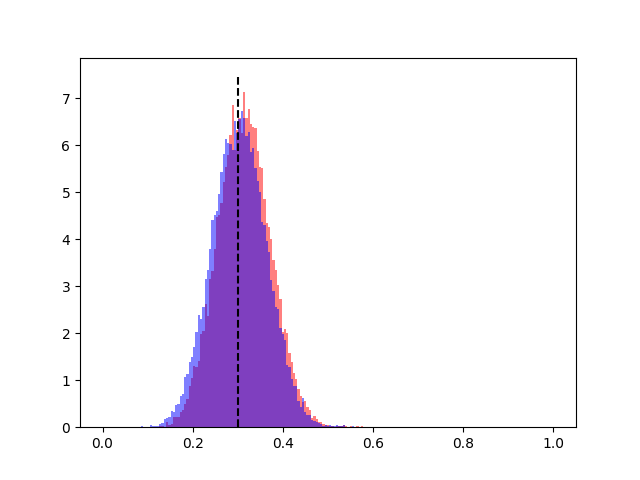

In [7]:
plt.close()
ax1 = plt.subplot()
ax1.hist(ell_k, bins=np.linspace(0, 1, 200, endpoint = True), density=True, alpha=0.5, label='Ellipticity along k', color = 'r')
ax1.hist(ell_k_cr, bins=np.linspace(0, 1, 200, endpoint = True), density=True, alpha=0.5, label='Ellipticity along k (corrected)', color = 'b')
ax1.vlines(ell, 0, ax1.get_ylim()[1], color='k', linestyle='--', label='True ellipticity')

plt.show()

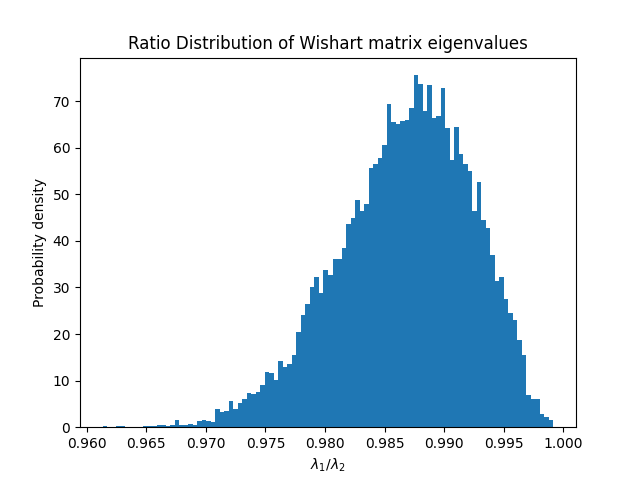

In [8]:
import numpy as np

M = 3
N = 20000
n_trial = 10000
ratios = []
for _ in range(n_trial):
    # 生成N个M维复高斯向量

    X = (np.random.randn(N, M) + 1j*np.random.randn(N, M)) / np.sqrt(2)
    S = X.conj().T @ X / N

    eigvals = np.linalg.eigvalsh(S)
    eigvals = np.sort(eigvals)[::-1]  # 从大到小
    ratios.append(eigvals[1]/eigvals[0])

import matplotlib.pyplot as plt
plt.close()
plt.hist(ratios, bins=100, density=True)
plt.xlabel(r'$\lambda_1/\lambda_2$')
plt.ylabel('Probability density')
plt.title('Ratio Distribution of Wishart matrix eigenvalues')
plt.show()


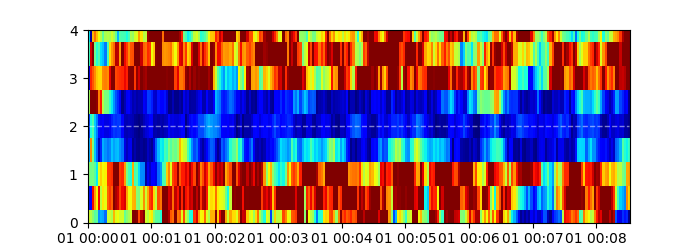

In [9]:
plt.close()
%matplotlib ipympl
fig = plt.gcf()
plt.gcf().set_size_inches(7.0, 2.5)
plt.subplots_adjust(hspace = 0.03, right = 0.90)
matplotlib.rcParams['figure.dpi'] = 120
plt.rcParams.update({'font.size': 10})

ax1 = plt.subplot(1, 1, 1)
# ax1.plot(sig_ut, sig_bx, 'b', label='Bx')
# ax1.plot(sig_ut, sig_by, 'g', label='By')
# ax1.plot(sig_ut, sig_bz, 'r', label='Bz')
ax1.pcolormesh(time, frequency, np.abs(ellipticity_along_k - ell), cmap='jet', vmax=0.5, vmin=0.0)
# ax1.pcolormesh(time, frequency, degree_of_polarization, cmap='jet', vmax=1.0, vmin=0.0)
# ax1.pcolormesh(time, frequency, coherence, cmap='jet', vmax=1.0, vmin=0.0)

# freq_idx = np.argmin(np.abs(frequency - omega / 2 / np.pi))
# print(np.mean(ellipticity_along_k[freq_idx, :] - 0.3), np.std(ellipticity_along_k[freq_idx, :] - 0.3))
ax1.hlines(omega / 2 / np.pi, time[0], time[-1], color='w', linestyle='--', linewidth=1.0, alpha=0.5)
# ax1.set_yscale('log')
ax1.set_ylim(0, omega / 2 / np.pi * 2.0)
plt.show()

# 0.01700414954323111 0.11557739950564232
# -0.015805499433818083 0.11589244861738289
# -0.0023059972968468884 0.12092601873490283
# 0.0703266856595991 0.14342085849093172


ValueError: too many values to unpack (expected 5)

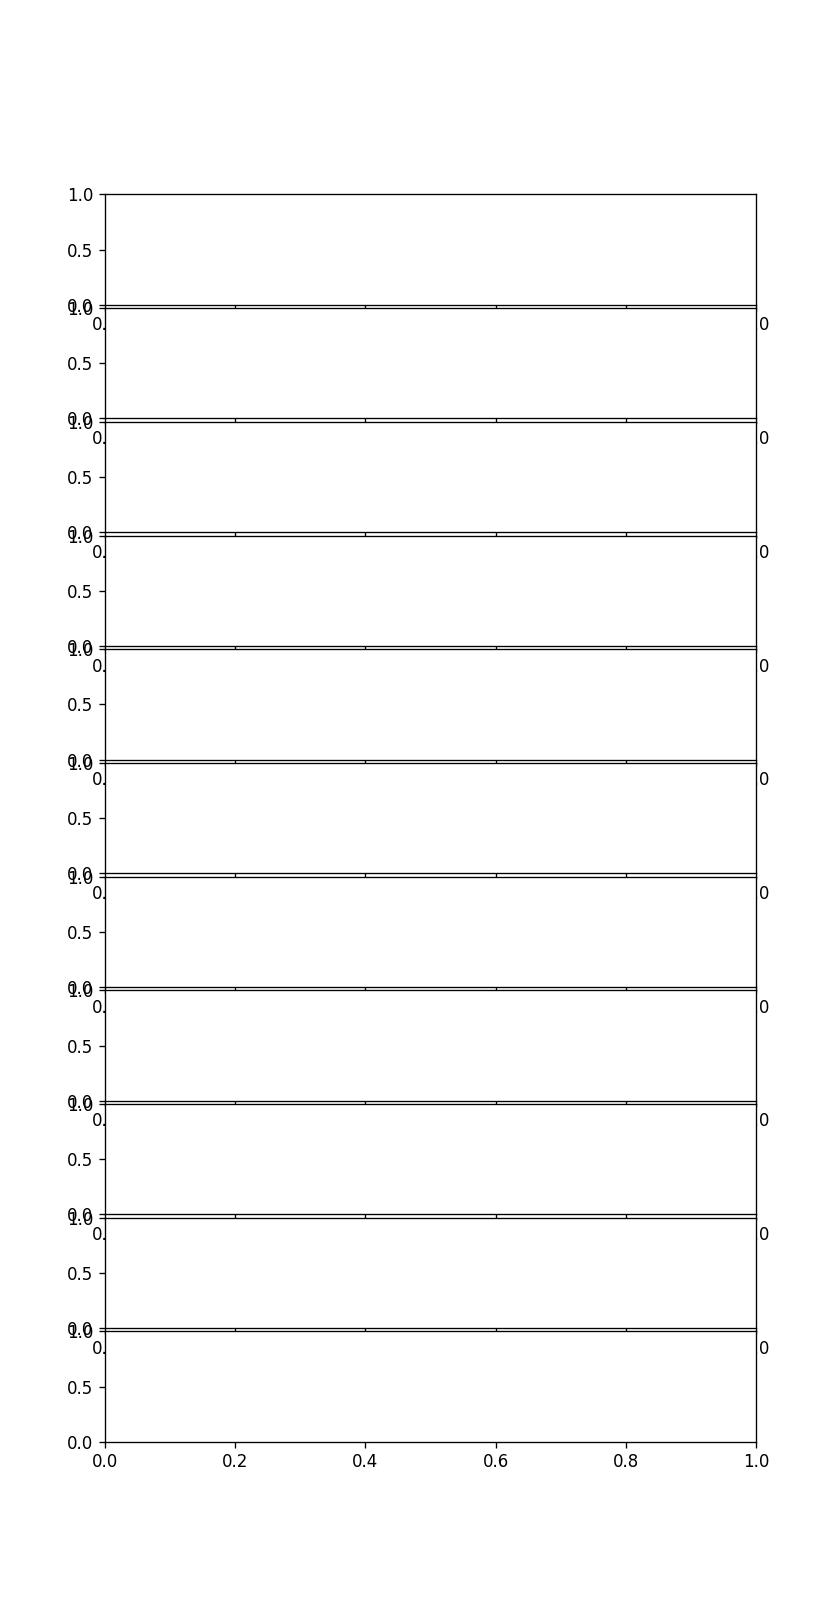

In [10]:
%matplotlib ipympl

plt.close()

fig = plt.gcf()
plt.gcf().set_size_inches(7.0, 13.5)
plt.subplots_adjust(hspace = 0.03, right = 0.90)
matplotlib.rcParams['figure.dpi'] = 120
plt.rcParams.update({'font.size': 10})

ax1 = plt.subplot(11, 1, 1)
ax2 = plt.subplot(11, 1, 2, sharex = ax1)
ax3 = plt.subplot(11, 1, 3, sharex = ax1, sharey = ax2)
ax4 = plt.subplot(11, 1, 4, sharex = ax1, sharey = ax2)
ax5 = plt.subplot(11, 1, 5, sharex = ax1, sharey = ax2)
ax6 = plt.subplot(11, 1, 6, sharex = ax1, sharey = ax2)
ax7 = plt.subplot(11, 1, 7, sharex = ax1, sharey = ax2)
ax8 = plt.subplot(11, 1, 8, sharex = ax1, sharey = ax2)
ax9 = plt.subplot(11, 1, 9, sharex = ax1, sharey = ax2)
ax10 = plt.subplot(11, 1, 10, sharex = ax1, sharey = ax2)
ax11 = plt.subplot(11, 1, 11, sharex = ax1, sharey = ax2)

use_wavelet = True

if use_wavelet:
    bandwidth = 12.0
    # log-scale
    scales = np.power(2, np.linspace(3, 12, 90 + 1))
    # linear-scale (for comparing with the windowed FFT)
    # scales = np.arange(2, 400)
    downsample = 1 # For comparing with the windowed FFT with a step of 50
    freq_window = 5
    time_window = 5
    downsample_signal = False # Downsample the signal before computing wavelet coefficients (True) or Downsample the coefficients after computing (False)

    time, frequency, coef_bx, psd_bx, avg_bx = wavelet_coef_psd(sig_ut, sig_bx, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_by, psd_by, avg_by = wavelet_coef_psd(sig_ut, sig_by, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bz, psd_bz, avg_bz = wavelet_coef_psd(sig_ut, sig_bz, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bt, psd_bt, avg_bt = wavelet_coef_psd(sig_ut, sig_bt, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)

    _, _, coef_ex, psd_ex, avg_ex = wavelet_coef_psd(sig_ut, sig_ex, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_ey, psd_ey, avg_ey = wavelet_coef_psd(sig_ut, sig_ey, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_ez, psd_ez, avg_ez = wavelet_coef_psd(sig_ut, sig_ez, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)

    coi = (np.sqrt(2) * bandwidth / (2 * np.pi) / frequency).astype(float)
    if isinstance(sig_ut[0], np.datetime64):
        coi = (1e9 * coi).astype('timedelta64[ns]')

else:

    freq_window = 2
    time_window = 2
    
    step = 2 ** 6
    window = 2 ** 12

    time, frequency, coef_bx, psd_bx, avg_bx = wfft_coef_psd(sig_ut, sig_bx, step = step, window = window)
    _, _, coef_by, psd_by, avg_by = wfft_coef_psd(sig_ut, sig_by, step = step, window = window)
    _, _, coef_bz, psd_bz, avg_bz = wfft_coef_psd(sig_ut, sig_bz, step = step, window = window)
    _, _, coef_bt, psd_bt, _ = wfft_coef_psd(sig_ut, sig_bt, step = step, window = window)

    _, _, coef_ex, psd_ex, avg_ex = wfft_coef_psd(sig_ut, sig_ex, step = step, window = window)
    _, _, coef_ey, psd_ey, avg_ey = wfft_coef_psd(sig_ut, sig_ey, step = step, window = window)
    _, _, coef_ez, psd_ez, avg_ez = wfft_coef_psd(sig_ut, sig_ez, step = step, window = window)

    downsample = 1


psd_b = (psd_bx + psd_by + psd_bz)
psd_e = (psd_ex + psd_ey + psd_ez)

psd_threshold = 1e-3 * np.nanmax(psd_b)

coef = np.array([coef_bx, coef_by, coef_bz]).transpose(1, 2, 0)
avg = np.array([avg_bx, avg_by, avg_bz]).T
magf_direction = ((avg.T) / np.linalg.norm(avg, axis = 1)).T

planarity, ellipticity_along_k, coherence, degree_of_polarization, vh = svd_wave_analysis(coef, freq_window = freq_window, time_window = time_window)
compressibility, ellipticity_along_b = fac_wave_analysis(coef, magf_direction)
wave_normal_angle = np.rad2deg(np.arccos(np.abs(np.sum(magf_direction * vh[:, :, 2, :], axis = -1))))
poynting_matrix = np.cross(np.array([coef_ex, coef_ey, coef_ez]).transpose(1, 2, 0), np.conj(np.array([coef_bx, coef_by, coef_bz])).transpose(1, 2, 0), axis = -1)
poynting_angle = np.rad2deg(np.arccos((np.sum(magf_direction * ((poynting_matrix.real.T) / np.linalg.norm(poynting_matrix.real.T, axis = 0)).T, axis = -1))))

_mask_idx = np.where(psd_b < psd_threshold)
compressibility[_mask_idx] = np.nan
ellipticity_along_k[_mask_idx] = np.nan
ellipticity_along_b[_mask_idx] = np.nan
wave_normal_angle[_mask_idx] = np.nan
poynting_angle[_mask_idx] = np.nan
coherence[_mask_idx] = np.nan
planarity[_mask_idx] = np.nan
degree_of_polarization[_mask_idx] = np.nan

ax1.plot(sig_ut, sig_bx + 3, 'r', lw = 0.5)
ax1.plot(sig_ut, sig_by, 'g', lw = 0.5)
ax1.plot(sig_ut, sig_bz - 3, 'b', lw = 0.5)

pc2 = ax2.pcolormesh(time, frequency, np.log10(psd_b), cmap='jet', shading='auto', vmax = 5.0, vmin = -1.0, rasterized = True)
# pc2 = ax2.pcolormesh(time, frequency, np.log10(psd_b * (1 - degree_of_polarization)), cmap='jet', shading='auto', vmax = 5.0, vmin = -1.0, rasterized = True)
pc3 = ax3.pcolormesh(time, frequency, np.log10(psd_e), cmap='jet', shading='auto', vmax = 16.0, vmin = 10.0, rasterized = True)
pc4 = ax4.pcolormesh(time, frequency, compressibility, cmap='jet', vmax = 1.0, vmin = 0, rasterized = True)
pc5 = ax5.pcolormesh(time, frequency, ellipticity_along_k, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)
pc6 = ax6.pcolormesh(time, frequency, ellipticity_along_b, cmap='jet', vmax = 1.0, vmin = -1.0, rasterized = True)
pc7 = ax7.pcolormesh(time, frequency, wave_normal_angle, cmap = 'Greys_r', vmax = 90.0, vmin = 0, rasterized = True)
pc8 = ax8.pcolormesh(time, frequency, poynting_angle, cmap='bwr', vmax = 180.0, vmin = 0, rasterized = True)
pc9 = ax9.pcolormesh(time, frequency, coherence, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)
pc10 = ax10.pcolormesh(time, frequency, planarity, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)
pc11 = ax11.pcolormesh(time, frequency, degree_of_polarization, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)

ax1.grid('on')
# ax2.set_ylim(450, 2450)
# ax2.set_yscale('log')
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

pcs = [None, pc2, pc3, pc4, pc5, pc6, pc7, pc8, pc9, pc10, pc11]
cbars = [None, None, None, None, None, None, None, None, None, None, None]

for i, ax in enumerate(plt.gcf().axes):
    ax.tick_params(which='both', direction='in', top=1, bottom=1, left=1, right=1)
    ax.tick_params(which='major', length=4, labelsize=10, pad=6)
    ax.xaxis.set_major_formatter(mdate.ConciseDateFormatter(ax.xaxis.get_major_locator(),offset_formats=['', '%Y', '%Y-%b', '%Y-%b-%d', '%Y-%b-%d', '%Y-%b-%d']))
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_label_coords(-0.10, 0.5)
    if ax != ax11:
        plt.setp(ax.get_xticklabels(), visible=False)
    if ax != ax1:
        if use_wavelet:
            ax.fill_betweenx(frequency, x1 = time[0], x2 = time[0] + coi, alpha = 0.6, color = '#CCCCCC', hatch = None)
            ax.fill_betweenx(frequency, x1 = time[-1], x2 = time[-1] - coi, alpha = 0.6, color = '#CCCCCC', hatch = None)

        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs = (1,)))
        ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='all'))
        
        cbar_ax = fig.add_axes(
            [ax.get_position().x1 + 0.01, ax.get_position().y0 + 0.01, 0.03, ax.get_position().y1 - ax.get_position().y0 - 0.02])
        cbars[i] = fig.colorbar(pcs[i], cax=cbar_ax)
        cbars[i].ax.tick_params(which='major', length=4, direction='in', pad=3)
        cbars[i].set_ticks([cbars[i].vmin, (cbars[i].vmax + cbars[i].vmin) / 2, cbars[i].vmax])
        ax.yaxis.set_major_locator(ticker.AutoLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.set_ylabel('Freq\n(Hz)')
    else:
        ax.set_ylabel('MAG\n(nT)')

plot_line = True

if plot_line:
    ax4_twinx = ax4.twinx()
    ax5_twinx = ax5.twinx()
    ax6_twinx = ax6.twinx()
    ax7_twinx = ax7.twinx()
    ax8_twinx = ax8.twinx()

    _freq_idx_max_psd_b = np.argmax(psd_b[3:], axis = 0) + 3
    ax2.plot(time, frequency[_freq_idx_max_psd_b], 'w--', lw = 1.0, path_effects = [pe.withStroke(linewidth=2.0, foreground="k")])

    line_dict = {
        'linestyle': '-',
        'linewidth' : 2.0,
        'alpha': 0.8,
        'color': 'm'
        }

    ax4_twinx.plot(time, compressibility[(_freq_idx_max_psd_b, np.arange(len(_freq_idx_max_psd_b)))], **line_dict)
    ax5_twinx.plot(time, ellipticity_along_k[(_freq_idx_max_psd_b, np.arange(len(_freq_idx_max_psd_b)))], **line_dict)
    ax6_twinx.plot(time, ellipticity_along_b[(_freq_idx_max_psd_b, np.arange(len(_freq_idx_max_psd_b)))], **line_dict)
    ax7_twinx.plot(time, wave_normal_angle[(_freq_idx_max_psd_b, np.arange(len(_freq_idx_max_psd_b)))], **line_dict)
    ax8_twinx.plot(time, poynting_angle[(_freq_idx_max_psd_b, np.arange(len(_freq_idx_max_psd_b)))], **line_dict)

    # ax4_twinx.plot(time, np.nansum(compressibility * psd_b, axis = 0) / np.nansum((compressibility ** 0) * psd_b, axis = 0), **line_dict)
    # ax5_twinx.plot(time, np.nansum(ellipticity_along_k * psd_b, axis = 0) / np.nansum((ellipticity_along_k ** 0) * psd_b, axis = 0), **line_dict)
    # ax6_twinx.plot(time, np.nansum(ellipticity_along_b * psd_b, axis = 0) / np.nansum((ellipticity_along_b ** 0) * psd_b, axis = 0), **line_dict)
    # ax7_twinx.plot(time, np.nansum(wave_normal_angle * psd_b, axis = 0) / np.nansum((wave_normal_angle ** 0) * psd_b, axis = 0), **line_dict)
    # ax8_twinx.plot(time, np.nansum(poynting_angle * psd_b, axis = 0) / np.nansum((poynting_angle ** 0) * psd_b, axis = 0), **line_dict)

    line_dict = {
        'linestyle': '--',
        'linewidth' : 1.0,
        'alpha': 0.8,
        'color': 'c',
        'path_effects' : [pe.withStroke(linewidth=1.5, foreground="w")]
    }

    ax4_twinx.plot(sig_ut, real_compressibility, **line_dict)
    ax5_twinx.plot(sig_ut, real_ellipticity_along_k[::], **line_dict)
    ax6_twinx.plot(sig_ut, real_ellipticity_along_b[::], **line_dict)
    ax7_twinx.plot(sig_ut, np.rad2deg(real_wna)[::], **line_dict)
    ax8_twinx.plot(sig_ut, np.rad2deg(real_poynting_angle)[::], **line_dict)

    ax4_twinx.set_ylim(0, 1.0)
    ax5_twinx.set_ylim(0.0, 1.0)
    ax6_twinx.set_ylim(-1.0, 1.0)
    ax7_twinx.set_ylim(0, 90.0)
    ax8_twinx.set_ylim(0, 180.0)

text_dict = {
    'fontsize': 10,
    'alpha': 1.0,
    'color': 'k',
    'path_effects': [pe.withStroke(linewidth=1.5, foreground="w")],
    'bbox' : dict(facecolor='#888888', alpha=0.0, edgecolor='none', pad=0),
    'ha': 'left',
    'va': 'top',
}

plt.text(0.05, 0.9, r'$\mathbf{(A)}$', transform=ax1.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(B)}$: $\mathrm{log_{10}(PSD)}$ ($\mathrm{nT^2/Hz}$)', transform=ax2.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(C)}$: $\mathrm{log_{10}(PSD)}$ ($\mathrm{mV^2/m^2/Hz}$)', transform=ax3.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(D)}$: Compressibility', transform=ax4.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(E)}$: Ellipticity Along $k$', transform=ax5.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(F)}$: Ellipticity Along $B$', transform=ax6.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(G)}$: Wave Normal Angle', transform=ax7.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(H)}$: Poynting Angle', transform=ax8.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(I)}$: Coherence', transform=ax9.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(J)}$: Planarity', transform=ax10.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(K)}$: Degree of Polarization', transform=ax11.transAxes, **text_dict)

plt.text(1.01, 0.80, r'$\mathrm{\delta B_x}$', ha = 'left', va='top', transform=ax1.transAxes, color = 'r')
plt.text(1.01, 0.60, r'$\mathrm{\delta B_y}$', ha='left', va='top', transform=ax1.transAxes, color = 'g')
plt.text(1.01, 0.40, r'$\mathrm{\delta B_z}$', ha='left', va='top', transform=ax1.transAxes, color = 'b')
plt.text(1.01, 0.20, r'$\mathrm{\delta B_t}$', ha='left', va='top', transform=ax1.transAxes, color = 'k')

ax2.set_yscale('log')
ax2.set_ylim(1e-3, 1e0)

ax1.set_title('Artifical Signal')

plt.show()

In [22]:
event_idx = 0

if event_idx == 0: # Use for my SSW-2024 proposal
    year = 2014
    doy = 81
elif event_idx == 1: # Sundberg et al., 2015 Figure 3: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015JA021499
    year = 2011
    doy = 170
elif event_idx == 2: # Boardson et al., 2012 Figure 2: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012JA017822
    year = 2011
    doy = 88
elif event_idx == 3: # Le et al., 2013 Figure 6: https://agupubs.onlinelibrary.wiley.com/doi/10.1002/jgra.50342
    year = 2011
    doy = 85
elif event_idx == 4: # Use for my SSW-2024 proposal
    year = 2015
    doy = 78
elif event_idx == 5: # Alex et al., 2025
    year = 2015
    doy = 86

mag_fullpath = glob.glob(f"/mnt/e/Data/MESSENGER/MAG/**/*MAG*{year % 100:02d}{doy:03d}*.TAB", recursive=True)
mag_fullpath = mag_fullpath[0] if mag_fullpath else None
mag_df = pd.read_csv(mag_fullpath, sep="\s+", header = None, engine = 'c')
mag_year = np.array(mag_df.iloc[:, 0])
mag_doy = np.array(mag_df.iloc[:, 1])
mag_hour = np.array(mag_df.iloc[:, 2])
mag_minute = np.array(mag_df.iloc[:, 3])
mag_second = np.array(mag_df.iloc[:, 4])
mag_met = np.array(mag_df.iloc[:, 5])
epoch_ut = np.datetime64('%4d-01-01 %02d:%02d:%06.3f' % (
    mag_year[0], mag_hour[0], mag_minute[0], mag_second[0])) + pd.to_timedelta((mag_doy[0]-1)*86400, unit='S')
mag_ut = np.datetime64('%4d-01-01 %02d:%02d:%06.3f' % (mag_year[0], mag_hour[0], mag_minute[0],
                    mag_second[0])) + pd.to_timedelta((mag_doy[0]-1)*86400+(mag_met-mag_met[0]), unit='S')
mag_ut = np.array(mag_ut).astype('datetime64[ns]')
rm = 2440

# I didn't do the transformation from MSM to aberrated MSM coordinates cause I am lazy

mag_bx = np.array(mag_df.iloc[:, 9])
mag_by = np.array(mag_df.iloc[:, 10])
mag_bz = np.array(mag_df.iloc[:, 11])
mag_bt = np.sqrt(mag_bx**2 + mag_by**2 + mag_bz**2)

mag_x = np.array(mag_df.iloc[:, 6])
mag_y = np.array(mag_df.iloc[:, 7])
mag_z = np.array(mag_df.iloc[:, 8]) - 0.196 * rm

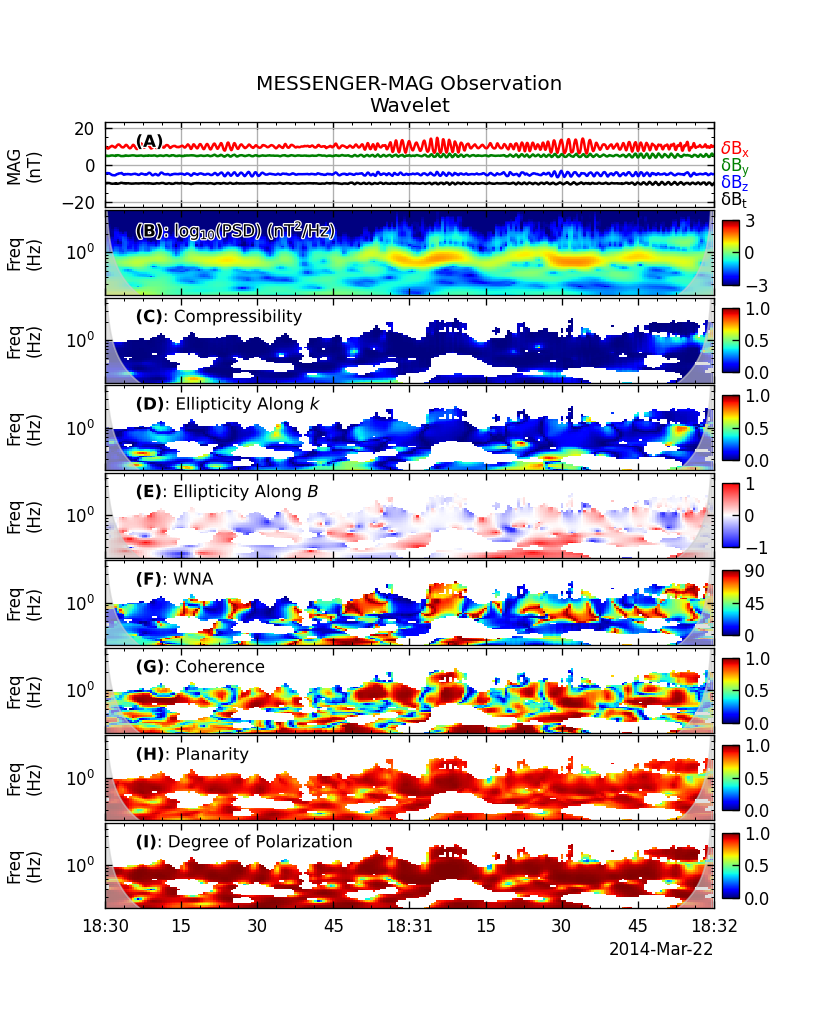

In [ ]:
%matplotlib ipympl

if event_idx == 0:
    start_ut = np.datetime64('2014-03-22T18:30:00')
    end_ut = np.datetime64('2014-03-22T18:32:00')
elif event_idx == 1:
    start_ut = np.datetime64('2011-06-19T12:45:00')
    end_ut = np.datetime64('2011-06-19T13:15:00') + np.timedelta64(30, 'm')
elif event_idx == 2:
    start_ut = np.datetime64('2011-03-29T02:20:00')
    end_ut = np.datetime64('2011-03-29T02:50:00')
elif event_idx == 3:
    start_ut = np.datetime64('2011-03-26T16:00:00')
    end_ut = np.datetime64('2011-03-26T18:00:00')
elif event_idx == 4:
    start_ut = np.datetime64('2015-03-19T12:05:00')
    end_ut = np.datetime64('2015-03-19T12:20:00')
elif event_idx == 5:
    start_ut = np.datetime64('2015-03-27T18:40:00')
    end_ut = np.datetime64('2015-03-27T18:50:00')

start_idx = np.searchsorted(mag_ut, start_ut)
end_idx = np.searchsorted(mag_ut, end_ut)

sig_ut = np.copy(mag_ut[start_idx:end_idx])
sig_bx = np.copy(mag_bx[start_idx:end_idx])
sig_by = np.copy(mag_by[start_idx:end_idx])
sig_bz = np.copy(mag_bz[start_idx:end_idx])
sig_bt = np.copy(mag_bt[start_idx:end_idx])

plt.close()

plt.gcf().set_size_inches(7.0, 8.5)
plt.subplots_adjust(hspace = 0.03, right = 0.85)
matplotlib.rcParams['figure.dpi'] = 120
plt.rcParams.update({'font.size': 10})
fig = plt.gcf()

ax1 = plt.subplot(9, 1, 1)
ax2 = plt.subplot(9, 1, 2, sharex = ax1)
ax3 = plt.subplot(9, 1, 3, sharex = ax1, sharey = ax2)
ax4 = plt.subplot(9, 1, 4, sharex = ax1, sharey = ax2)
ax5 = plt.subplot(9, 1, 5, sharex = ax1, sharey = ax2)
ax6 = plt.subplot(9, 1, 6, sharex = ax1, sharey = ax2)
ax7 = plt.subplot(9, 1, 7, sharex = ax1, sharey = ax2)
ax8 = plt.subplot(9, 1, 8, sharex = ax1, sharey = ax2)
ax9 = plt.subplot(9, 1, 9, sharex = ax1, sharey = ax2)

import scipy.signal
sos = scipy.signal.butter(10, 0.2, 'hp', fs=20, output='sos')

filtered_sig_bx = scipy.signal.sosfiltfilt(sos, sig_bx)
filtered_sig_by = scipy.signal.sosfiltfilt(sos, sig_by)
filtered_sig_bz = scipy.signal.sosfiltfilt(sos, sig_bz)
filtered_sig_bt = scipy.signal.sosfiltfilt(sos, sig_bt)

use_wavelet = True

if use_wavelet:
    bandwidth = 6.0
    # log-scale
    scales = np.power(2, np.linspace(1, 10, 100))
    # linear-scale (for comparing with the windowed FFT)
    # scales = np.arange(2, 400)
    downsample = 10 # For comparing with the windowed FFT with a step of 50
    freq_window = 3
    time_window = 7
    downsample_signal = False # Downsample the signal before computing wavelet coefficients (True) or Downsample the coefficients after computing (False)

    time, frequency, coef_bx, psd_bx, avg_bx = wavelet_coef_psd(sig_ut, sig_bx, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_by, psd_by, avg_by = wavelet_coef_psd(sig_ut, sig_by, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bz, psd_bz, avg_bz = wavelet_coef_psd(sig_ut, sig_bz, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bt, psd_bt, avg_bt = wavelet_coef_psd(sig_ut, sig_bt, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    coi = (np.sqrt(2) * bandwidth / (2 * np.pi) / frequency).astype(float)
    if isinstance(sig_ut[0], np.datetime64):
        coi = (1e9 * coi).astype('timedelta64[ns]')

else: # Use windowed FFT
    step = 50
    window = 400
    
    freq_window = 3
    time_window = 7

    time, frequency, coef_bx, psd_bx, avg_bx = wfft_coef_psd(sig_ut, sig_bx, step = step, window = window)
    _, _, coef_by, psd_by, avg_by = wfft_coef_psd(sig_ut, sig_by, step = step, window = window)
    _, _, coef_bz, psd_bz, avg_bz = wfft_coef_psd(sig_ut, sig_bz, step = step, window = window)
    _, _, coef_bt, psd_bt, _ = wfft_coef_psd(sig_ut, sig_bt, step = step, window = window)
    

coef = np.array([coef_bx, coef_by, coef_bz]).transpose(1, 2, 0)
avg = np.array([avg_bx, avg_by, avg_bz]).T
magf_direction = ((avg.T) / np.linalg.norm(avg, axis = 1)).T

psd = (psd_bx + psd_by + psd_bz)

psd_threshold = 1e-1

compressibility = (psd_bt) / psd

planarity, ellipticity_along_k, coherence, degree_of_polarization, vh = svd_wave_analysis(coef, freq_window = freq_window, time_window = time_window)

compressibility, ellipticity_along_b = fac_wave_analysis(coef, magf_direction)
wave_normal_angle = np.rad2deg(np.arccos(np.abs(np.sum(magf_direction * vh[:, :, 2, :], axis = -1))))

pc2 = ax2.pcolormesh(time, frequency, np.log10(psd * degree_of_polarization), cmap='jet', shading='auto', vmax = 3.0, vmin = -3)

_mask_idx = np.where(psd < psd_threshold)
compressibility[_mask_idx] = np.nan
ellipticity_along_k[_mask_idx] = np.nan
ellipticity_along_b[_mask_idx] = np.nan
planarity[_mask_idx] = np.nan
coherence[_mask_idx] = np.nan
wave_normal_angle[_mask_idx] = np.nan
degree_of_polarization[_mask_idx] = np.nan

# ax1.plot(sig_ut, sig_bx, 'r')
# ax1.plot(sig_ut, sig_by, 'g')
# ax1.plot(sig_ut, sig_bz, 'b')
# ax1.plot(sig_ut, sig_bt, 'k')

ax1.plot(sig_ut, filtered_sig_bx + 10, 'r')
ax1.plot(sig_ut, filtered_sig_by + 5, 'g')
ax1.plot(sig_ut, filtered_sig_bz - 5, 'b')
ax1.plot(sig_ut, filtered_sig_bt - 10, 'k')

# pc2 = ax2.pcolormesh(time, frequency, np.log10(psd), cmap='jet', shading='auto', vmax = 3.0, vmin = -3)
pc3 = ax3.pcolormesh(time, frequency, compressibility, cmap='jet', vmax = 1.0, vmin = 0)
pc4 = ax4.pcolormesh(time, frequency, ellipticity_along_k, cmap='jet', vmax = 1.0, vmin = 0.0)
pc5 = ax5.pcolormesh(time, frequency, ellipticity_along_b, cmap='bwr', vmax = 1.0, vmin = -1.0)
pc6 = ax6.pcolormesh(time, frequency, wave_normal_angle, cmap='jet', vmax = 90.0, vmin = 0)
pc7 = ax7.pcolormesh(time, frequency, coherence, cmap='jet', vmax = 1.0, vmin = 0.0)
pc8 = ax8.pcolormesh(time, frequency, planarity, cmap='jet', vmax = 1.0, vmin = 0.0)
# WNA in this event seems varies a lot since this wave is nearly linearly polarized
pc9 = ax9.pcolormesh(time, frequency, degree_of_polarization, cmap='jet', vmax = 1.0, vmin = 0)

ax1.set_ylim(-23, 23)

ax1.set_xlim(start_ut, end_ut)
ax1.grid('on')

ax2.set_yscale('log')
ax2.set_ylim(0.2, 5.0)
# ax2.set_ylim(frequency[-1], frequency[0])

pcs = [None, pc2, pc3, pc4, pc5, pc6, pc7, pc8, pc9]
cbars = [None, None, None, None, None, None, None, None, None, None]

for i, ax in enumerate(plt.gcf().axes):
    ax.tick_params(which='both', direction='in', top=1, bottom=1, left=1, right=1)
    ax.tick_params(which='major', length=4, labelsize=10, pad=6)
    ax.xaxis.set_major_formatter(mdate.ConciseDateFormatter(ax.xaxis.get_major_locator(),offset_formats=['', '%Y', '%Y-%b', '%Y-%b-%d', '%Y-%b-%d', '%Y-%b-%d']))
    # ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_label_coords(-0.10, 0.5)

    if ax != ax9:
        plt.setp(ax.get_xticklabels(), visible=False)
        ax.yaxis.set_major_locator(ticker.AutoLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    if ax != ax1:
        if use_wavelet:
            ax.fill_betweenx(frequency, x1 = time[0], x2 = time[0] + coi, alpha = 0.6, color = '#CCCCCC', hatch = None)
            ax.fill_betweenx(frequency, x1 = time[-1], x2 = time[-1] - coi, alpha = 0.6, color = '#CCCCCC', hatch = None)

        cbar_ax = fig.add_axes(
            [ax.get_position().x1 + 0.01, ax.get_position().y0 + 0.01, 0.02, ax.get_position().y1 - ax.get_position().y0 - 0.02])
        cbars[i] = fig.colorbar(pcs[i], cax = cbar_ax)
        cbars[i].ax.tick_params(which = 'major', length = 4, direction = 'in', pad = 3)
        cbars[i].set_ticks([cbars[i].vmin, (cbars[i].vmax + cbars[i].vmin) / 2, cbars[i].vmax])
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs = (1,)))
        ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='all'))
        
        ax.set_ylabel('Freq\n(Hz)')
    else:
        ax.set_ylabel('MAG\n(nT)')


text_dict = {
    'fontsize': 10,
    'alpha': 1.0,
    'color': 'k',
    'path_effects': [pe.withStroke(linewidth=1.5, foreground="w")],
    'bbox' : dict(facecolor='#888888', alpha=0.0, edgecolor='none', pad=0),
    'ha': 'left',
    'va': 'top',
}

plt.text(0.05, 0.9, r'$\mathbf{(A)}$', transform=ax1.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(B)}$: $\mathrm{log_{10}(PSD)}$ ($\mathrm{nT^2/Hz}$)', transform=ax2.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(C)}$: Compressibility', transform=ax3.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(D)}$: Ellipticity Along $k$', transform=ax4.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(E)}$: Ellipticity Along $B$', transform=ax5.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(F)}$: WNA', transform=ax6.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(G)}$: Coherence', transform=ax7.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(H)}$: Planarity', transform=ax8.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(I)}$: Degree of Polarization', transform=ax9.transAxes, **text_dict)

plt.text(1.01, 0.80, r'$\mathrm{\delta B_x}$', ha='left', va='top', transform=ax1.transAxes, color = 'r')
plt.text(1.01, 0.60, r'$\mathrm{\delta B_y}$', ha='left', va='top', transform=ax1.transAxes, color = 'g')
plt.text(1.01, 0.40, r'$\mathrm{\delta B_z}$', ha='left', va='top', transform=ax1.transAxes, color = 'b')
plt.text(1.01, 0.20, r'$\mathrm{\delta B_t}$', ha='left', va='top', transform=ax1.transAxes, color = 'k')

ax1.set_title('MESSENGER-MAG Observation\n' + ("Wavelet" if use_wavelet else "Windowed FFT"))

# plt.savefig('MESSENGER-MAG Observation ' + ("Wavelet" if use_wavelet else "Windowed FFT") + '.png',bbox_inches='tight',dpi=300)

plt.show()

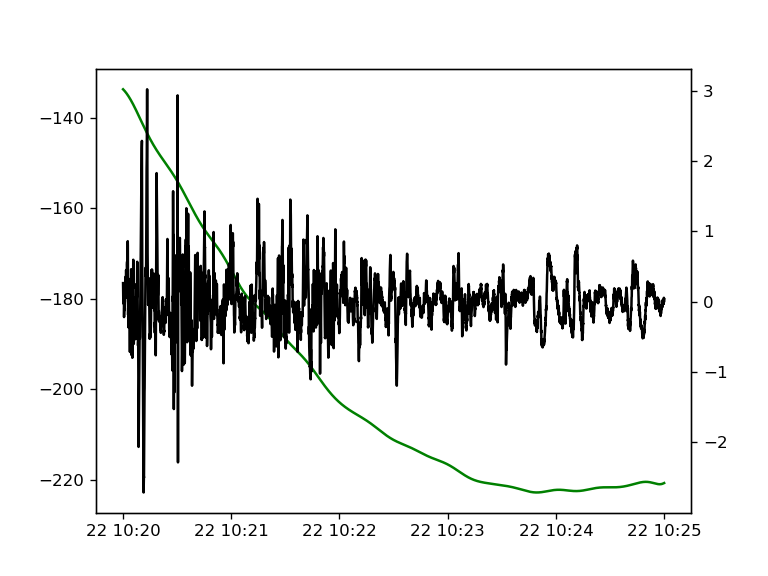

In [37]:
plt.close()
ax1 = plt.subplot(1, 1, 1)


start_ut = np.datetime64('2014-03-22T10:20:00')
end_ut = np.datetime64('2014-03-22T10:25:00')

start_idx = np.searchsorted(mag_ut, start_ut)
end_idx = np.searchsorted(mag_ut, end_ut)

# start_idx = 0
# end_idx = -1

sig_ut = np.copy(mag_ut[start_idx:end_idx])
sig_bx = np.copy(mag_bx[start_idx:end_idx])
sig_by = np.copy(mag_by[start_idx:end_idx])
sig_bz = np.copy(mag_bz[start_idx:end_idx])
sig_bt = np.copy(mag_bt[start_idx:end_idx])

sos = scipy.signal.butter(10, 0.05, 'hp', fs=20, output='sos')

# filtered_sig_bx = scipy.signal.sosfiltfilt(sos, sig_bx)
filtered_sig_by = scipy.signal.sosfiltfilt(sos, sig_by)
# filtered_sig_bz = scipy.signal.sosfiltfilt(sos, sig_bz)
# filtered_sig_bt = scipy.signal.sosfiltfilt(sos, sig_bt)

# ax1.plot(sig_ut, sig_bx, 'r')
ax1.plot(sig_ut, sig_by - filtered_sig_by, 'g')
# ax1.plot(sig_ut, sig_bz, 'b')
ax1_twinx = ax1.twinx()
ax1_twinx.plot(sig_ut, filtered_sig_by, 'k')


plt.show()

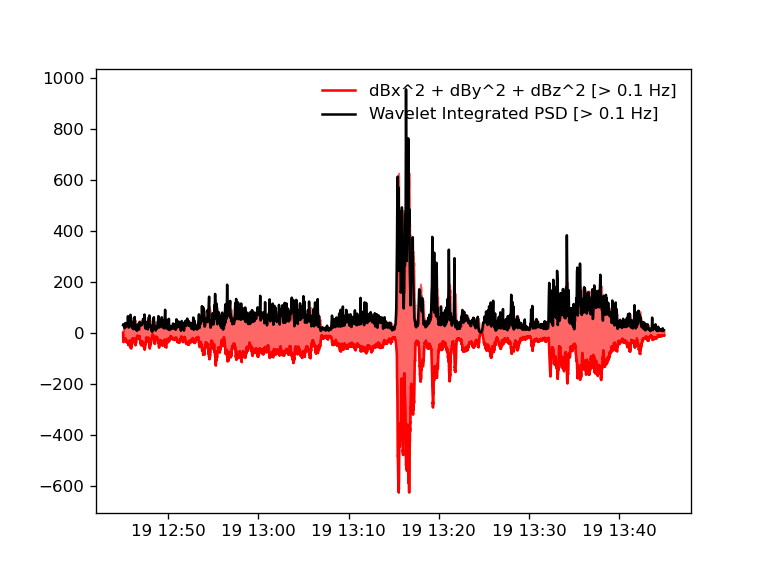

In [65]:
plt.close()
ax1 = plt.subplot(1, 1, 1)

df = -np.diff(frequency)
df = np.append(df, df[-1] ** 2 / df[-2])

# df = np.diff(frequency)
# df = np.append(df, df[0])

_psd = np.copy(psd)
_psd[frequency < 0.1] = 0.0
# Numerical integration of the PSD to get the wave power
integrated_psd = np.sum((_psd.T) * df, axis = 1)

# _observed_mean_half_square = (sig_bx ** 2 + sig_by ** 2 + sig_bz ** 2)
_observed_mean_half_square = bn.move_std(filtered_sig_bx, window = 200, min_count = 1) ** 2
_observed_mean_half_square += bn.move_std(filtered_sig_by, window = 200, min_count = 1) ** 2
_observed_mean_half_square += bn.move_std(filtered_sig_bz, window = 200, min_count = 1) ** 2


ax1.fill_between(sig_ut, y1 = -_observed_mean_half_square, y2 = _observed_mean_half_square, alpha = 0.6, color = 'r', hatch = None)
ax1.plot(sig_ut, -_observed_mean_half_square, 'r', label = 'dBx^2 + dBy^2 + dBz^2 [> 0.1 Hz]')
ax1.plot(time, integrated_psd, 'k', label = 'Wavelet Integrated PSD [> 0.1 Hz]')
ax1.legend(frameon=False, ncols = 1)

plt.show()

In [450]:
# This part could be slow especially when you use wavelet to do the analysis as ERG data is very large
# It is used for comparing the analysis result in this script with the result from ISEE_WAVE package (IDL)
# Ref: Matsuda et al., 2021: https://doi.org/10.1186/s40623-021-01430-3
import spacepy.pycdf

erg_mgf_fullpath = glob.glob(f"/mnt/e/Data/ERG/*mgf*sgi*.cdf", recursive = True)[0]
erg_wfc_b_waveform_fullpath = glob.glob(f"/mnt/e/Data/ERG/*b_waveform_wp65khz_sgi*.cdf", recursive = True)[0]
erg_wfc_e_waveform_fullpath = glob.glob(f"/mnt/e/Data/ERG/*e_waveform_wp65khz_sgi*.cdf", recursive = True)[0]

print(erg_mgf_fullpath, erg_wfc_b_waveform_fullpath, erg_wfc_e_waveform_fullpath)
# DC magnetic field data: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/mgf/l2/64hz/2017/03/erg_mgf_l2_64hz_sgi_2017033102_v03.05.cdf
# 65kHz magnetic field waveform data: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/pwe/wfc/l2/waveform/2017/03/erg_pwe_wfc_l2_b_waveform_wp65khz_sgi_2017033102_v03_01.cdf
# 65kHz electric field waveform data: https://ergsc.isee.nagoya-u.ac.jp/data/ergsc/satellite/erg/pwe/wfc/l2/waveform/2017/03/erg_pwe_wfc_l2_e_waveform_wp65khz_sgi_2017033102_v03_01.cdf

# These data are all in a spinning reference frame (Spinning satellite Geometry Inertia, SGI),
# but we do not need to do the transformation as long as the time window 
# (or the length of the supporting set for wavelet) is shorter enough compared to the spin period

erg_mgf_cdf = spacepy.pycdf.CDF(erg_mgf_fullpath)
erg_wfc_b_waveform_cdf = spacepy.pycdf.CDF(erg_wfc_b_waveform_fullpath)
erg_wfc_e_waveform_cdf = spacepy.pycdf.CDF(erg_wfc_e_waveform_fullpath)

erg_wfc_b_waveform_epoch = np.array(erg_wfc_b_waveform_cdf['epoch'])
erg_wfc_b_waveform_rate = np.array(erg_wfc_b_waveform_cdf['sampling_rate'])
erg_wfc_b_waveform_bx = np.array(erg_wfc_b_waveform_cdf['Bx_waveform'])
erg_wfc_b_waveform_by = np.array(erg_wfc_b_waveform_cdf['By_waveform'])
erg_wfc_b_waveform_bz = np.array(erg_wfc_b_waveform_cdf['Bz_waveform'])

erg_wfc_e_waveform_epoch = np.array(erg_wfc_e_waveform_cdf['epoch'])
erg_wfc_e_waveform_rate = np.array(erg_wfc_e_waveform_cdf['sampling_rate'])
erg_wfc_e_waveform_ex = np.array(erg_wfc_e_waveform_cdf['Ex_waveform'])
erg_wfc_e_waveform_ey = np.array(erg_wfc_e_waveform_cdf['Ey_waveform'])

erg_mgf_epoch = np.array(erg_mgf_cdf['epoch_64hz'])
erg_mgf_mag = np.array(erg_mgf_cdf['mag_64hz_sgi'])

# These are some data clean processing steps, which are not necessary for the analysis
import scipy.interpolate
erg_magf_interp = scipy.interpolate.interp1d(erg_mgf_epoch.astype('datetime64[ns]').astype(float), erg_mgf_mag, axis = 0, bounds_error = False, fill_value = 'extrapolate')
erg_magf_interp(erg_mgf_epoch.astype('datetime64[ns]').astype(float)).shape

start_ut = np.datetime64('2017-03-31T02:24:35')
end_ut = np.datetime64('2017-03-31T02:24:50')

_epoch_start_idx = np.searchsorted(erg_wfc_b_waveform_epoch, start_ut) + 1
_epoch_end_idx = np.searchsorted(erg_wfc_b_waveform_epoch, end_ut)

sig_ut = np.datetime64(erg_wfc_b_waveform_epoch[_epoch_start_idx]).astype('datetime64[ns]') + (np.arange(0, 512 * (_epoch_end_idx - _epoch_start_idx)) / (erg_wfc_b_waveform_rate[_epoch_start_idx] * 1e3) * 1e9).astype('timedelta64[ns]')
sig_bx = np.copy(erg_wfc_b_waveform_bx[_epoch_start_idx : _epoch_end_idx].flatten())
sig_by = np.copy(erg_wfc_b_waveform_by[_epoch_start_idx : _epoch_end_idx].flatten())
sig_bz = np.copy(erg_wfc_b_waveform_bz[_epoch_start_idx : _epoch_end_idx].flatten())

_epoch_start_idx += -1
_epoch_end_idx += -1

sig_ut = np.datetime64(erg_wfc_e_waveform_epoch[_epoch_start_idx]).astype('datetime64[ns]') + (np.arange(0, 512 * (_epoch_end_idx - _epoch_start_idx)) / (erg_wfc_e_waveform_rate[_epoch_start_idx] * 1e3) * 1e9).astype('timedelta64[ns]')
sig_ex = np.copy(erg_wfc_e_waveform_ex[_epoch_start_idx : _epoch_end_idx].flatten())
sig_ey = np.copy(erg_wfc_e_waveform_ey[_epoch_start_idx : _epoch_end_idx].flatten())

_start_idx = np.where((sig_bx > -1e30))[0]

sig_ut = sig_ut[_start_idx]
sig_bx = sig_bx[_start_idx]
sig_by = sig_by[_start_idx]
sig_bz = sig_bz[_start_idx]
sig_bt = np.sqrt(sig_bx ** 2 + sig_by ** 2 + sig_bz ** 2)
sig_ex = sig_ex[_start_idx]
sig_ey = sig_ey[_start_idx]

_start_idx = np.where((sig_ex < -1e30))[0]
sig_ex[_start_idx] = 0.0
sig_ey[_start_idx] = 0.0

# magnetic field in peco-tesla

filtered_sig_bx = np.copy(sig_bx)
filtered_sig_by = np.copy(sig_by)
filtered_sig_bz = np.copy(sig_bz)

sig_bx += 1e3 * erg_magf_interp(sig_ut.astype('datetime64[ns]').astype(float))[:, 0]
sig_by += 1e3 * erg_magf_interp(sig_ut.astype('datetime64[ns]').astype(float))[:, 1]
sig_bz += 1e3 * erg_magf_interp(sig_ut.astype('datetime64[ns]').astype(float))[:, 2]
sig_bt = np.sqrt(sig_bx ** 2 + sig_by ** 2 + sig_bz ** 2)

# Estimate Ez based on E \cdot B = 0 [Faraday's Law]
sig_ez = (- sig_ex * sig_bx - sig_ey * sig_by) / sig_bz

ModuleNotFoundError: No module named 'spacepy'

/tmp/ipykernel_501561/3112656793.py:83: RuntimeWarning: invalid value encountered in divide
  poynting_angle = np.rad2deg(np.arccos((np.sum(magf_direction * ((poynting_matrix.real.T) / np.linalg.norm(poynting_matrix.real.T, axis = 0)).T, axis = -1))))


NameError: name 'filtered_sig_bx' is not defined

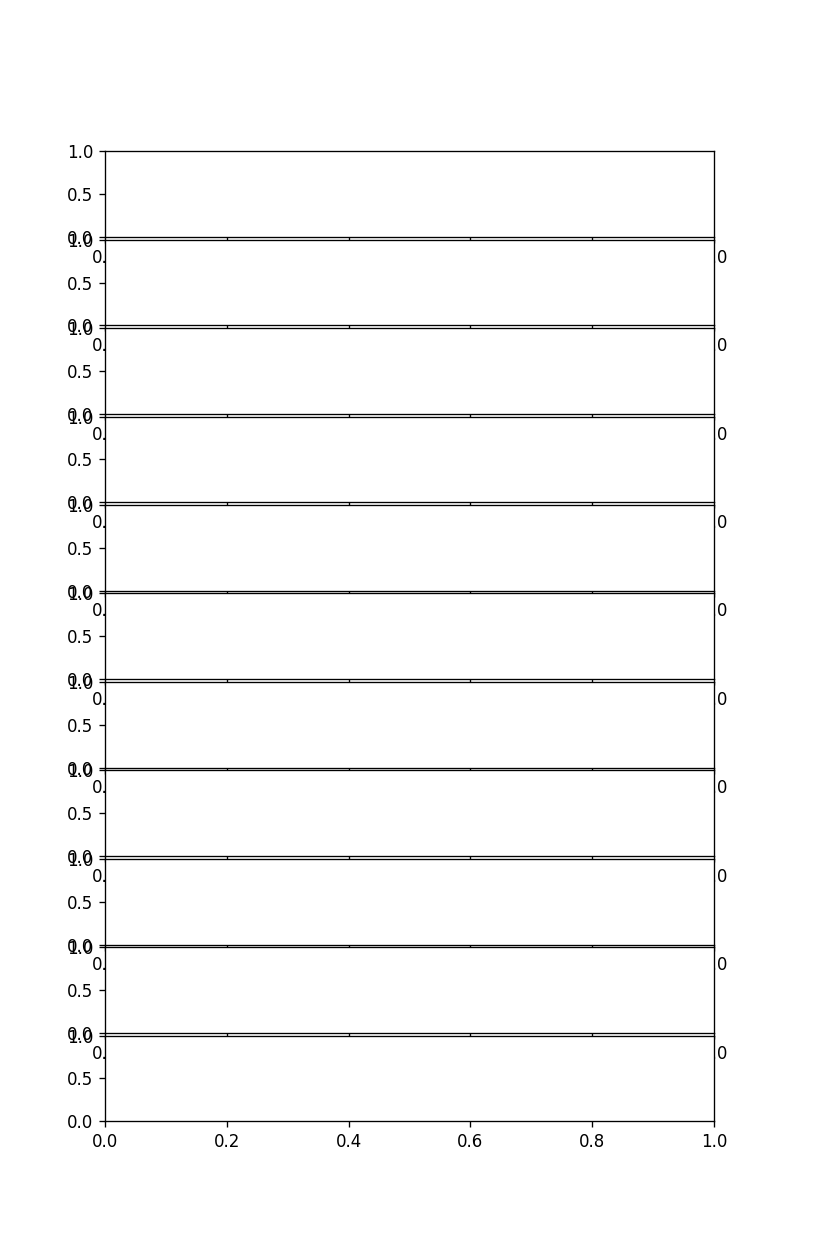

In [5]:
%matplotlib ipympl

plt.close()

plt.gcf().set_size_inches(7.0, 10.5)
plt.subplots_adjust(hspace = 0.03, right = 0.85)
matplotlib.rcParams['figure.dpi'] = 120
plt.rcParams.update({'font.size': 10})
fig = plt.gcf()

ax1 = plt.subplot(11, 1, 1)
ax2 = plt.subplot(11, 1, 2, sharex = ax1)
ax3 = plt.subplot(11, 1, 3, sharex = ax1, sharey = ax2)
ax4 = plt.subplot(11, 1, 4, sharex = ax1, sharey = ax2)
ax5 = plt.subplot(11, 1, 5, sharex = ax1, sharey = ax2)
ax6 = plt.subplot(11, 1, 6, sharex = ax1, sharey = ax2)
ax7 = plt.subplot(11, 1, 7, sharex = ax1, sharey = ax2)
ax8 = plt.subplot(11, 1, 8, sharex = ax1, sharey = ax2)
ax9 = plt.subplot(11, 1, 9, sharex = ax1, sharey = ax2)
ax10 = plt.subplot(11, 1, 10, sharex = ax1, sharey = ax2)
ax11 = plt.subplot(11, 1, 11, sharex = ax1, sharey = ax2)

use_wavelet = True
if use_wavelet:
    bandwidth = 12.0
    # log-scale
    scales = np.power(2, np.linspace(1, 7, 30))
    # linear-scale (for comparing with the windowed FFT)
    scales = np.arange(16, 64, 1) / 10

    downsample = 10 # For comparing with the windowed FFT with a step of 50
    freq_window = 3
    time_window = 7
    downsample_signal = True # Downsample the signal before computing wavelet coefficients (True) or Downsample the coefficients after computing (False)

    time, frequency, coef_bx, psd_bx, avg_bx = wavelet_coef_psd(sig_ut, sig_bx, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_by, psd_by, avg_by = wavelet_coef_psd(sig_ut, sig_by, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bz, psd_bz, avg_bz = wavelet_coef_psd(sig_ut, sig_bz, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bt, psd_bt, avg_bt = wavelet_coef_psd(sig_ut, sig_bt, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)

    _, _, coef_ex, psd_ex, avg_ex = wavelet_coef_psd(sig_ut, sig_ex, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_ey, psd_ey, avg_ey = wavelet_coef_psd(sig_ut, sig_ey, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_ez, psd_ez, avg_ez = wavelet_coef_psd(sig_ut, sig_ez, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)

else:

    step = 1024
    window = 4096

    freq_window = 1
    time_window = 3

    time, frequency, coef_bx, psd_bx, avg_bx = wfft_coef_psd(sig_ut, sig_bx, step = step, window = window)
    _, _, coef_by, psd_by, avg_by = wfft_coef_psd(sig_ut, sig_by, step = step, window = window)
    _, _, coef_bz, psd_bz, avg_bz = wfft_coef_psd(sig_ut, sig_bz, step = step, window = window)
    _, _, coef_bt, psd_bt, _ = wfft_coef_psd(sig_ut, sig_bt, step = step, window = window)

    _, _, coef_ex, psd_ex, avg_ex = wfft_coef_psd(sig_ut, sig_ex, step = step, window = window)
    _, _, coef_ey, psd_ey, avg_ey = wfft_coef_psd(sig_ut, sig_ey, step = step, window = window)
    _, _, coef_ez, psd_ez, avg_ez = wfft_coef_psd(sig_ut, sig_ez, step = step, window = window)

psd_b = (psd_bx + psd_by + psd_bz)
compressibility = (psd_bt) / psd_b

psd_e = (psd_ex + psd_ey + psd_ez)

coef = np.array([coef_bx, coef_by, coef_bz]).transpose(1, 2, 0)
avg = np.array([avg_bx, avg_by, avg_bz]).T
magf_direction = ((avg.T) / np.linalg.norm(avg, axis = 1)).T

psd = (psd_bx + psd_by + psd_bz)

psd_threshold = 1e-3 * np.max(psd)

compressibility = (psd_bt) / psd

planarity, ellipticity_along_k, coherence, degree_of_polarization, vh = svd_wave_analysis(coef, freq_window = freq_window, time_window = time_window)

compressibility, ellipticity_along_b = fac_wave_analysis(coef, magf_direction)
wave_normal_angle = np.rad2deg(np.arccos(np.abs(np.sum(magf_direction * vh[:, :, 2, :], axis = -1))))

poynting_matrix = np.cross(np.array([coef_ex, coef_ey, coef_ez]).transpose(1, 2, 0), np.conj(np.array([coef_bx, coef_by, coef_bz])).transpose(1, 2, 0), axis = -1)
poynting_angle = np.rad2deg(np.arccos((np.sum(magf_direction * ((poynting_matrix.real.T) / np.linalg.norm(poynting_matrix.real.T, axis = 0)).T, axis = -1))))


psd_threshold = 1e0
_mask_idx = np.where(psd_b < psd_threshold)
compressibility[_mask_idx] = np.nan
ellipticity_along_k[_mask_idx] = np.nan
ellipticity_along_b[_mask_idx] = np.nan
wave_normal_angle[_mask_idx] = np.nan
poynting_angle[_mask_idx] = np.nan
coherence[_mask_idx] = np.nan
planarity[_mask_idx] = np.nan
degree_of_polarization[_mask_idx] = np.nan

ax1.plot(sig_ut, filtered_sig_bx + 300, 'r', lw = 0.5)
ax1.plot(sig_ut, filtered_sig_by, 'g', lw = 0.5)
ax1.plot(sig_ut, filtered_sig_bz - 300, 'b', lw = 0.5)

pc2 = ax2.pcolormesh(time, frequency, np.log10(psd_b), cmap='jet', shading='auto', vmax = 3.0, vmin = -3, rasterized = True)
pc3 = ax3.pcolormesh(time, frequency, np.log10(psd_e), cmap='jet', shading='auto', vmax = 1.0, vmin = -5, rasterized = True)
pc4 = ax4.pcolormesh(time, frequency, compressibility, cmap='jet', vmax = 1.0, vmin = 0, rasterized = True)
pc5 = ax5.pcolormesh(time, frequency, ellipticity_along_k, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)
pc6 = ax6.pcolormesh(time, frequency, ellipticity_along_b, cmap='jet', vmax = 1.0, vmin = -1.0, rasterized = True)
pc7 = ax7.pcolormesh(time, frequency, wave_normal_angle, cmap = 'bwr', vmax = 180.0, vmin = 0, rasterized = True)
pc8 = ax8.pcolormesh(time, frequency, poynting_angle, cmap='bwr', vmax = 180.0, vmin = 0, rasterized = True)
pc9 = ax9.pcolormesh(time, frequency, coherence, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)
pc10 = ax10.pcolormesh(time, frequency, planarity, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)
pc11 = ax11.pcolormesh(time, frequency, degree_of_polarization, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)

ax1.set_xlim(np.datetime64('2017-03-31T02:24:40'), np.datetime64('2017-03-31T02:24:45'))
ax1.grid('on')
ax2.set_ylim(450, 2450)
# ax2.set_yscale('log')
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

pcs = [None, pc2, pc3, pc4, pc5, pc6, pc7, pc8, pc9, pc10, pc11]
cbars = [None, None, None, None, None, None, None, None, None, None, None]

for i, ax in enumerate(plt.gcf().axes):
    ax.tick_params(which='both', direction='in', top=1, bottom=1, left=1, right=1)
    ax.tick_params(which='major', length=4, labelsize=10, pad=6)
    ax.xaxis.set_major_formatter(mdate.ConciseDateFormatter(ax.xaxis.get_major_locator(),offset_formats=['', '%Y', '%Y-%b', '%Y-%b-%d', '%Y-%b-%d', '%Y-%b-%d']))
    ax.xaxis.set_major_locator(mdate.SecondLocator(np.arange(0, 60, 2)))
    ax.xaxis.set_minor_locator(mdate.SecondLocator(np.arange(0, 60, 1)))
    ax.yaxis.set_label_coords(-0.10, 0.5)
    if ax != ax11:
        plt.setp(ax.get_xticklabels(), visible=False)
    if ax != ax1:
        cbar_ax = fig.add_axes(
            [ax.get_position().x1 + 0.01, ax.get_position().y0 + 0.01, 0.03, ax.get_position().y1 - ax.get_position().y0 - 0.02])
        cbars[i] = fig.colorbar(pcs[i], cax=cbar_ax)
        cbars[i].ax.tick_params(which='major', length=4, direction='in', pad=3)
        cbars[i].set_ticks([cbars[i].vmin, (cbars[i].vmax + cbars[i].vmin) / 2, cbars[i].vmax])
        ax.yaxis.set_major_locator(ticker.AutoLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.set_ylabel('Freq\n(Hz)')
    else:
        ax.set_ylabel('MAG\n(nT)')


text_dict = {
    'fontsize': 10,
    'alpha': 1.0,
    'color': 'k',
    'path_effects': [pe.withStroke(linewidth=1.5, foreground="w")],
    'bbox' : dict(facecolor='#888888', alpha=0.0, edgecolor='none', pad=0),
    'ha': 'left',
    'va': 'top',
}

plt.text(0.05, 0.9, r'$\mathbf{(A)}$', transform=ax1.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(B)}$: $\mathrm{log_{10}(PSD)}$ ($\mathrm{nT^2/Hz}$)', transform=ax2.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(C)}$: $\mathrm{log_{10}(PSD)}$ ($\mathrm{mV^2/m^2/Hz}$)', transform=ax3.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(D)}$:Compressibility', transform=ax4.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(E)}$:Ellipticity Along $k$', transform=ax5.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(F)}$:Ellipticity Along $B$', transform=ax6.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(G)}$:Wave Normal Angle', transform=ax7.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(H)}$:Poynting Angle', transform=ax8.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(I)}$:Coherence', transform=ax9.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(J)}$:Planarity', transform=ax10.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(K)}$:Degree of Polarization', transform=ax11.transAxes, **text_dict)

plt.text(1.01, 0.80, r'$\mathrm{\delta B_x}$', ha = 'left', va='top', transform=ax1.transAxes, color = 'r')
plt.text(1.01, 0.60, r'$\mathrm{\delta B_y}$', ha='left', va='top', transform=ax1.transAxes, color = 'g')
plt.text(1.01, 0.40, r'$\mathrm{\delta B_z}$', ha='left', va='top', transform=ax1.transAxes, color = 'b')
plt.text(1.01, 0.20, r'$\mathrm{\delta B_t}$', ha='left', va='top', transform=ax1.transAxes, color = 'k')

ax1.set_title('ERG-WFC Observation')

plt.show()

In [1]:
# Use for Debuging

N = 2 ** 15
t = np.linspace(0, 5000, N)
dt = t[1] - t[0]

# Generate Vector Signal
sig_ut = np.copy(t * 1e9).astype('datetime64[ns]')
sig_bx = 0 + 2.0 * np.sin(2 * np.pi * t / 10.0)
sig_by = -45 * t / t[-1] + 1.5 * np.sin(2 * np.pi * t / 10.0 + np.pi / 2) + 3.0 * np.sin(2 * np.pi * t / 100.0 - 1 * np.pi / 2)
sig_bz = 30 + 3.0 * np.sin(2 * np.pi * t / 100.0)
sig_bt = np.sqrt(sig_bx ** 2 + sig_by ** 2 + sig_bz ** 2)

sig_ex = np.zeros(N)
sig_ey = np.zeros(N)
sig_ez = np.zeros(N)

noise_level = 0.0

sig_bx += np.random.randn(N) * noise_level
sig_by += np.random.randn(N) * noise_level
sig_bz += np.random.randn(N) * noise_level

%matplotlib ipympl

plt.close()


plt.gcf().set_size_inches(7.0, 10.5)
plt.subplots_adjust(hspace = 0.03, right = 0.85)
matplotlib.rcParams['figure.dpi'] = 120
plt.rcParams.update({'font.size': 10})

ax1 = plt.subplot(11, 1, 1)
ax2 = plt.subplot(11, 1, 2, sharex = ax1)
ax3 = plt.subplot(11, 1, 3, sharex = ax1, sharey = ax2)
ax4 = plt.subplot(11, 1, 4, sharex = ax1, sharey = ax2)
ax5 = plt.subplot(11, 1, 5, sharex = ax1, sharey = ax2)
ax6 = plt.subplot(11, 1, 6, sharex = ax1, sharey = ax2)
ax7 = plt.subplot(11, 1, 7, sharex = ax1, sharey = ax2)
ax8 = plt.subplot(11, 1, 8, sharex = ax1, sharey = ax2)
ax9 = plt.subplot(11, 1, 9, sharex = ax1, sharey = ax2)
ax10 = plt.subplot(11, 1, 10, sharex = ax1, sharey = ax2)
ax11 = plt.subplot(11, 1, 11, sharex = ax1, sharey = ax2)

use_wavelet = False

if use_wavelet:
    bandwidth = 12.0
    # log-scale
    scales = np.power(2, np.linspace(1, 7, 100))
    # linear-scale (for comparing with the windowed FFT)
    scales = np.arange(2, 400)
    downsample = 10 # For comparing with the windowed FFT with a step of 50
    freq_window = 3
    time_window = 7
    downsample_signal = True # Downsample the signal before computing wavelet coefficients (True) or Downsample the coefficients after computing (False)

    time, frequency, coef_bx, psd_bx, avg_bx = wavelet_coef_psd(sig_ut, sig_bx, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_by, psd_by, avg_by = wavelet_coef_psd(sig_ut, sig_by, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bz, psd_bz, avg_bz = wavelet_coef_psd(sig_ut, sig_bz, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bt, psd_bt, avg_bt = wavelet_coef_psd(sig_ut, sig_bt, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)

    _, _, coef_ex, psd_ex, avg_ex = wavelet_coef_psd(sig_ut, sig_ex, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_ey, psd_ey, avg_ey = wavelet_coef_psd(sig_ut, sig_ey, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_ez, psd_ez, avg_ez = wavelet_coef_psd(sig_ut, sig_ez, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)

    coi = (np.sqrt(2) * bandwidth / (2 * np.pi) / frequency).astype(float)
    if isinstance(sig_ut[0], np.datetime64):
        coi = (1e9 * coi).astype('timedelta64[ns]')

else:

    freq_window = 1
    time_window = 3
    
    step = 1024
    window = 4096

    time, frequency, coef_bx, psd_bx, avg_bx = wfft_coef_psd(sig_ut, sig_bx, step = step, window = window)
    _, _, coef_by, psd_by, avg_by = wfft_coef_psd(sig_ut, sig_by, step = step, window = window)
    _, _, coef_bz, psd_bz, avg_bz = wfft_coef_psd(sig_ut, sig_bz, step = step, window = window)
    _, _, coef_bt, psd_bt, _ = wfft_coef_psd(sig_ut, sig_bt, step = step, window = window)

    _, _, coef_ex, psd_ex, avg_ex = wfft_coef_psd(sig_ut, sig_ex, step = step, window = window)
    _, _, coef_ey, psd_ey, avg_ey = wfft_coef_psd(sig_ut, sig_ey, step = step, window = window)
    _, _, coef_ez, psd_ez, avg_ez = wfft_coef_psd(sig_ut, sig_ez, step = step, window = window)



psd_b = (psd_bx + psd_by + psd_bz)
psd_e = (psd_ex + psd_ey + psd_ez)

psd_threshold = 1e-3 * np.max(psd_b)

coef = np.array([coef_bx, coef_by, coef_bz]).transpose(1, 2, 0)
avg = np.array([avg_bx, avg_by, avg_bz]).T
magf_direction = ((avg.T) / np.linalg.norm(avg, axis = 1)).T

planarity, ellipticity_along_k, coherence, degree_of_polarization, vh = svd_wave_analysis(coef, freq_window = freq_window, time_window = time_window)
compressibility, ellipticity_along_b = fac_wave_analysis(coef, magf_direction)
wave_normal_angle = np.rad2deg(np.arccos(np.abs(np.sum(magf_direction * vh[:, :, 2, :], axis = -1))))
poynting_matrix = np.cross(np.array([coef_ex, coef_ey, coef_ez]).transpose(1, 2, 0), np.conj(np.array([coef_bx, coef_by, coef_bz])).transpose(1, 2, 0), axis = -1)
poynting_angle = np.rad2deg(np.arccos((np.sum(magf_direction * ((poynting_matrix.real.T) / np.linalg.norm(poynting_matrix.real.T, axis = 0)).T, axis = -1))))

psd_threshold = 1e1
_mask_idx = np.where(psd_b < psd_threshold)
compressibility[_mask_idx] = np.nan
ellipticity_along_k[_mask_idx] = np.nan
ellipticity_along_b[_mask_idx] = np.nan
wave_normal_angle[_mask_idx] = np.nan
poynting_angle[_mask_idx] = np.nan
coherence[_mask_idx] = np.nan
planarity[_mask_idx] = np.nan
degree_of_polarization[_mask_idx] = np.nan

ax1.plot(sig_ut, sig_bx + 3, 'r', lw = 0.5)
ax1.plot(sig_ut, sig_by, 'g', lw = 0.5)
ax1.plot(sig_ut, sig_bz - 3, 'b', lw = 0.5)

pc2 = ax2.pcolormesh(time, frequency, np.log10(psd_b), cmap='jet', shading='auto', vmax = 3.0, vmin = -3, rasterized = True)
pc3 = ax3.pcolormesh(time, frequency, np.log10(psd_e), cmap='jet', shading='auto', vmax = 1.0, vmin = -5, rasterized = True)
pc4 = ax4.pcolormesh(time, frequency, compressibility, cmap='jet', vmax = 1.0, vmin = 0, rasterized = True)
pc5 = ax5.pcolormesh(time, frequency, ellipticity_along_k, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)
pc6 = ax6.pcolormesh(time, frequency, ellipticity_along_b, cmap='jet', vmax = 1.0, vmin = -1.0, rasterized = True)
pc7 = ax7.pcolormesh(time, frequency, wave_normal_angle, cmap = 'bwr', vmax = 180.0, vmin = 0, rasterized = True)
pc8 = ax8.pcolormesh(time, frequency, poynting_angle, cmap='bwr', vmax = 180.0, vmin = 0, rasterized = True)
pc9 = ax9.pcolormesh(time, frequency, coherence, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)
pc10 = ax10.pcolormesh(time, frequency, planarity, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)
pc11 = ax11.pcolormesh(time, frequency, degree_of_polarization, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)

ax1.grid('on')
# ax2.set_ylim(450, 2450)
ax2.set_yscale('log')
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

pcs = [None, pc2, pc3, pc4, pc5, pc6, pc7, pc8, pc9, pc10, pc11]
cbars = [None, None, None, None, None, None, None, None, None, None, None]

for i, ax in enumerate(plt.gcf().axes):
    ax.tick_params(which='both', direction='in', top=1, bottom=1, left=1, right=1)
    ax.tick_params(which='major', length=4, labelsize=10, pad=6)
    ax.xaxis.set_major_formatter(mdate.ConciseDateFormatter(ax.xaxis.get_major_locator(),offset_formats=['', '%Y', '%Y-%b', '%Y-%b-%d', '%Y-%b-%d', '%Y-%b-%d']))
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_label_coords(-0.10, 0.5)
    if ax != ax11:
        plt.setp(ax.get_xticklabels(), visible=False)
    if ax != ax1:
        if use_wavelet:
            ax.fill_betweenx(frequency, x1 = time[0], x2 = time[0] + coi, alpha = 0.6, color = '#CCCCCC', hatch = None)
            ax.fill_betweenx(frequency, x1 = time[-1], x2 = time[-1] - coi, alpha = 0.6, color = '#CCCCCC', hatch = None)

        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs = (1,)))
        ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='all'))
        
        cbar_ax = fig.add_axes(
            [ax.get_position().x1 + 0.01, ax.get_position().y0 + 0.01, 0.03, ax.get_position().y1 - ax.get_position().y0 - 0.02])
        cbars[i] = fig.colorbar(pcs[i], cax=cbar_ax)
        cbars[i].ax.tick_params(which='major', length=4, direction='in', pad=3)
        cbars[i].set_ticks([cbars[i].vmin, (cbars[i].vmax + cbars[i].vmin) / 2, cbars[i].vmax])
        ax.yaxis.set_major_locator(ticker.AutoLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.set_ylabel('Freq\n(Hz)')
    else:
        ax.set_ylabel('MAG\n(nT)')


text_dict = {
    'fontsize': 10,
    'alpha': 1.0,
    'color': 'k',
    'path_effects': [pe.withStroke(linewidth=1.5, foreground="w")],
    'bbox' : dict(facecolor='#888888', alpha=0.0, edgecolor='none', pad=0),
    'ha': 'left',
    'va': 'top',
}

plt.text(0.05, 0.9, r'$\mathbf{(A)}$', transform=ax1.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(B)}$: $\mathrm{log_{10}(PSD)}$ ($\mathrm{nT^2/Hz}$)', transform=ax2.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(C)}$: $\mathrm{log_{10}(PSD)}$ ($\mathrm{mV^2/m^2/Hz}$)', transform=ax3.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(D)}$:Compressibility', transform=ax4.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(E)}$:Ellipticity Along $k$', transform=ax5.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(F)}$:Ellipticity Along $B$', transform=ax6.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(G)}$:Wave Normal Angle', transform=ax7.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(H)}$:Poynting Angle', transform=ax8.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(I)}$:Coherence', transform=ax9.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(J)}$:Planarity', transform=ax10.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(K)}$:Degree of Polarization', transform=ax11.transAxes, **text_dict)

plt.text(1.01, 0.80, r'$\mathrm{\delta B_x}$', ha = 'left', va='top', transform=ax1.transAxes, color = 'r')
plt.text(1.01, 0.60, r'$\mathrm{\delta B_y}$', ha='left', va='top', transform=ax1.transAxes, color = 'g')
plt.text(1.01, 0.40, r'$\mathrm{\delta B_z}$', ha='left', va='top', transform=ax1.transAxes, color = 'b')
plt.text(1.01, 0.20, r'$\mathrm{\delta B_t}$', ha='left', va='top', transform=ax1.transAxes, color = 'k')

ax1.set_title('Artifical Signal')

plt.show()

NameError: name 'np' is not defined

In [13]:
(B0 / np.linalg.norm(B0, axis = 1)[:, None]).shape

(65536, 3)

In [5]:
import numpy as np
np.cumsum(np.arange(1, 1000, 1)).shape

(999,)

/tmp/ipykernel_501561/2110046335.py:165: RuntimeWarning: divide by zero encountered in divide
  poynting_angle = np.rad2deg(np.arccos((np.sum(magf_direction * ((poynting_matrix.real.T) / np.linalg.norm(poynting_matrix.real.T, axis = 0)).T, axis = -1))))
/home/jtzhao/anaconda3/envs/spectral/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_501561/2110046335.py:165: RuntimeWarning: invalid value encountered in arccos
  poynting_angle = np.rad2deg(np.arccos((np.sum(magf_direction * ((poynting_matrix.real.T) / np.linalg.norm(poynting_matrix.real.T, axis = 0)).T, axis = -1))))
/home/jtzhao/anaconda3/envs/spectral/lib/python3.13/site-packages/ipympl/backend_nbagg.py:335: UserWarning: AutoMinorLocator does not work on logarithmic scales
  self.figure.savefig(buf, format='png', dpi='figure')


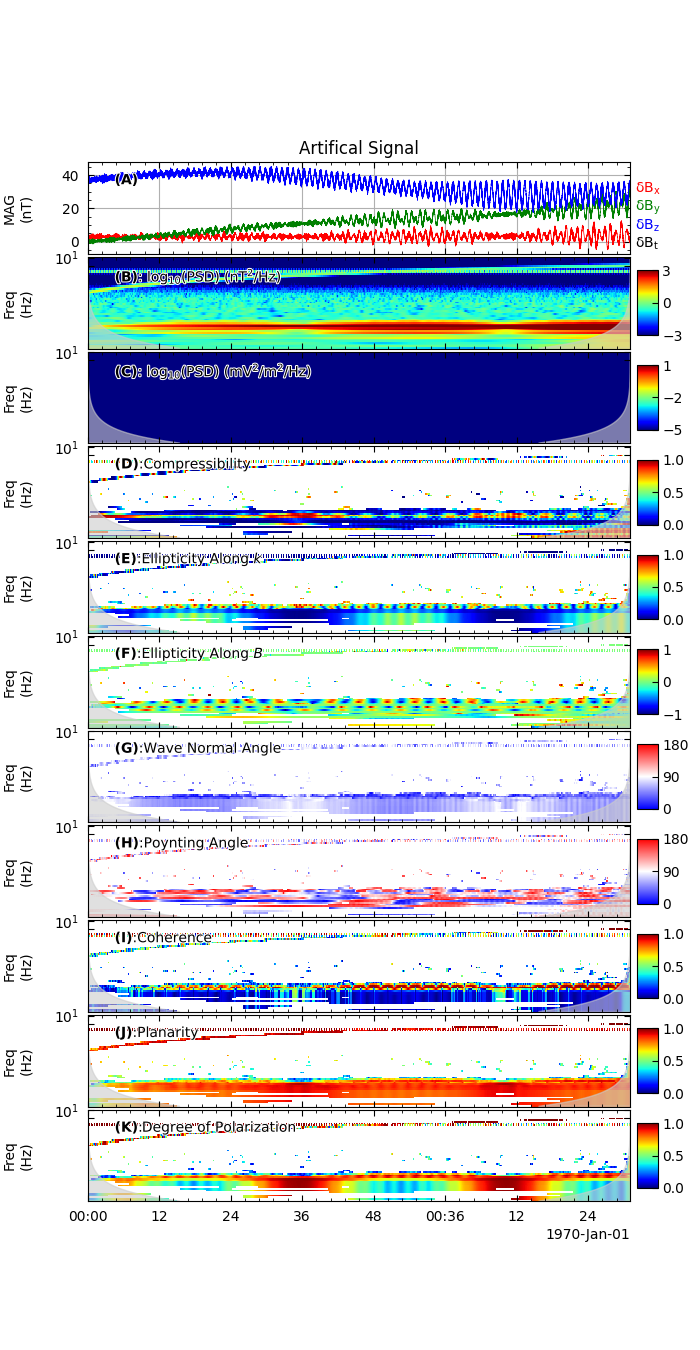

In [3]:
from scipy.signal import butter, filtfilt

# ==== 时间参数 ====
fs = 20
npts = 2 ** 16
t = np.linspace(0, (npts - 1) / fs, npts)

# ==== 背景磁场 B0(t) ====
theta_b = 0.5 * np.pi * np.sin(2 * np.pi * 0.00002 * t)
phi_b = 0.5 * np.pi * np.cos(2 * np.pi * 0.00001 * t)
strength_b = 40 + 5 * np.sin(2 * np.pi * 0.0003 * t)
bx = strength_b * np.sin(theta_b) * np.cos(phi_b)
by = strength_b * np.sin(theta_b) * np.sin(phi_b)
bz = strength_b * np.cos(theta_b)
B0 = np.stack([bx, by, bz], axis=1)  # nT

# ==== 波动 1：低频、增长、传播方向缓变 ====
freq1 = 0.03
amp1 = np.linspace(0, 10, npts)
theta1 = 0.3 * np.pi * np.cos(2 * np.pi * 0.0004 * t + 1.5)
phi1 = 0.4 * np.pi * np.sin(2 * np.pi * 0.006 * t + 0.8)
dir1 = np.stack([
    np.sin(theta1) * np.cos(phi1),
    np.sin(theta1) * np.sin(phi1),
    np.cos(theta1)
], axis=1)
sig1 = amp1[:, None] * np.sin(2 * np.pi * freq1 * t)[:, None] * dir1
v1 = 300e3  # m/s
E1 = v1 * np.cross(dir1, sig1) * 1e-6  # mV/m

# ==== 波动 2：高频、调幅、传播方向变化 ====
freq2 = 3.0
mod2 = 1 + 0.8 * np.sin(2 * np.pi * 0.1 * t)
theta2 = np.pi * 0.3 * np.sin(2 * np.pi * 0.01 * t)
phi2 = np.pi * 0.3 * np.cos(2 * np.pi * 0.01 * t)
dir2 = np.stack([
    np.sin(theta2) * np.cos(phi2),
    np.sin(theta2) * np.sin(phi2),
    np.cos(theta2)
], axis=1)
sin2 = np.sin(2 * np.pi * freq2 * t)
sig2 = mod2[:, None] * sin2[:, None] * dir2
v2 = 100e3  # m/s
E2 = v2 * np.cross(dir2, sig2) * 1e-6  # mV/m

# ==== 波动 3：扫频、随机振幅、传播方向缓变 ====
freq3 = np.linspace(0.5, 5, npts)
phase3 = 2 * np.pi * np.cumsum(freq3) / fs
amp3 = 1.0 + 0.5 * np.random.randn(npts)
b3, a3 = butter(3, 0.01)
amp3 = filtfilt(b3, a3, amp3)
theta3 = 0.5 * np.pi * np.sin(2 * np.pi * 0.005 * t)
phi3 = 0.5 * np.pi * np.cos(2 * np.pi * 0.004 * t)
dir3 = np.stack([
    np.sin(theta3) * np.cos(phi3),
    np.sin(theta3) * np.sin(phi3),
    np.cos(theta3)
], axis=1)
sig3 = (amp3 * np.sin(phase3))[:, None] * dir3
v3 = np.linspace(50e3, 2000e3, npts)  # m/s
E3 = v3[:, None] * np.cross(dir3, sig3) * 1e-6  # mV/m

# ==== 红噪声 ====
white = np.random.randn(npts, 3) * 1.0
b_r, a_r = butter(2, 0.05)
red_noise = filtfilt(b_r, a_r, white, axis=0) * 1.0  # nT
E_noise = np.zeros_like(red_noise)

# ==== 合成总磁场 B 与电场 E ====
B = B0 + sig1 + sig2 + sig3 + red_noise  # nT
E = E1 + E2 + E3 + E_noise               # mV/m


# Generate Vector Signal
sig_ut = np.copy(t * 1e9).astype('datetime64[ns]')
sig_bx = B[:, 0]
sig_by = B[:, 1]
sig_bz = B[:, 2]
sig_bt = np.sqrt(sig_bx ** 2 + sig_by ** 2 + sig_bz ** 2)

sig_ex = E[:, 0]
sig_ey = E[:, 1]
sig_ez = E[:, 2]

%matplotlib ipympl

plt.close()

fig = plt.gcf()
plt.gcf().set_size_inches(7.0, 13.5)
plt.subplots_adjust(hspace = 0.03, right = 0.90)
matplotlib.rcParams['figure.dpi'] = 120
plt.rcParams.update({'font.size': 10})

ax1 = plt.subplot(11, 1, 1)
ax2 = plt.subplot(11, 1, 2, sharex = ax1)
ax3 = plt.subplot(11, 1, 3, sharex = ax1, sharey = ax2)
ax4 = plt.subplot(11, 1, 4, sharex = ax1, sharey = ax2)
ax5 = plt.subplot(11, 1, 5, sharex = ax1, sharey = ax2)
ax6 = plt.subplot(11, 1, 6, sharex = ax1, sharey = ax2)
ax7 = plt.subplot(11, 1, 7, sharex = ax1, sharey = ax2)
ax8 = plt.subplot(11, 1, 8, sharex = ax1, sharey = ax2)
ax9 = plt.subplot(11, 1, 9, sharex = ax1, sharey = ax2)
ax10 = plt.subplot(11, 1, 10, sharex = ax1, sharey = ax2)
ax11 = plt.subplot(11, 1, 11, sharex = ax1, sharey = ax2)

use_wavelet = True

if use_wavelet:
    bandwidth = 12.0
    # log-scale
    scales = np.power(2, np.linspace(1, 12, 55))
    # linear-scale (for comparing with the windowed FFT)
    # scales = np.arange(2, 400)
    downsample = 3 # For comparing with the windowed FFT with a step of 50
    freq_window = 20
    time_window = 20
    downsample_signal = False # Downsample the signal before computing wavelet coefficients (True) or Downsample the coefficients after computing (False)

    time, frequency, coef_bx, psd_bx, avg_bx = wavelet_coef_psd(sig_ut, sig_bx, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_by, psd_by, avg_by = wavelet_coef_psd(sig_ut, sig_by, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bz, psd_bz, avg_bz = wavelet_coef_psd(sig_ut, sig_bz, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_bt, psd_bt, avg_bt = wavelet_coef_psd(sig_ut, sig_bt, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)

    _, _, coef_ex, psd_ex, avg_ex = wavelet_coef_psd(sig_ut, sig_ex, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_ey, psd_ey, avg_ey = wavelet_coef_psd(sig_ut, sig_ey, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)
    _, _, coef_ez, psd_ez, avg_ez = wavelet_coef_psd(sig_ut, sig_ez, scales, bandwidth, downsample = downsample, downsample_signal = downsample_signal)

    coi = (np.sqrt(2) * bandwidth / (2 * np.pi) / frequency).astype(float)
    if isinstance(sig_ut[0], np.datetime64):
        coi = (1e9 * coi).astype('timedelta64[ns]')

else:

    freq_window = 1
    time_window = 3
    
    step = 4096
    window = 8192

    time, frequency, coef_bx, psd_bx, avg_bx = wfft_coef_psd(sig_ut, sig_bx, step = step, window = window)
    _, _, coef_by, psd_by, avg_by = wfft_coef_psd(sig_ut, sig_by, step = step, window = window)
    _, _, coef_bz, psd_bz, avg_bz = wfft_coef_psd(sig_ut, sig_bz, step = step, window = window)
    _, _, coef_bt, psd_bt, _ = wfft_coef_psd(sig_ut, sig_bt, step = step, window = window)

    _, _, coef_ex, psd_ex, avg_ex = wfft_coef_psd(sig_ut, sig_ex, step = step, window = window)
    _, _, coef_ey, psd_ey, avg_ey = wfft_coef_psd(sig_ut, sig_ey, step = step, window = window)
    _, _, coef_ez, psd_ez, avg_ez = wfft_coef_psd(sig_ut, sig_ez, step = step, window = window)



psd_b = (psd_bx + psd_by + psd_bz)
psd_e = (psd_ex + psd_ey + psd_ez)

psd_threshold = 1e-4 * np.max(psd_b)

coef = np.array([coef_bx, coef_by, coef_bz]).transpose(1, 2, 0)
avg = np.array([avg_bx, avg_by, avg_bz]).T
magf_direction = ((avg.T) / np.linalg.norm(avg, axis = 1)).T

planarity, ellipticity_along_k, coherence, degree_of_polarization, vh = svd_wave_analysis(coef, freq_window = freq_window, time_window = time_window)
compressibility, ellipticity_along_b = fac_wave_analysis(coef, magf_direction)
wave_normal_angle = np.rad2deg(np.arccos(np.abs(np.sum(magf_direction * vh[:, :, 2, :], axis = -1))))
poynting_matrix = np.cross(np.array([coef_ex, coef_ey, coef_ez]).transpose(1, 2, 0), np.conj(np.array([coef_bx, coef_by, coef_bz])).transpose(1, 2, 0), axis = -1)
poynting_angle = np.rad2deg(np.arccos((np.sum(magf_direction * ((poynting_matrix.real.T) / np.linalg.norm(poynting_matrix.real.T, axis = 0)).T, axis = -1))))

_mask_idx = np.where(psd_b < psd_threshold)
compressibility[_mask_idx] = np.nan
ellipticity_along_k[_mask_idx] = np.nan
ellipticity_along_b[_mask_idx] = np.nan
wave_normal_angle[_mask_idx] = np.nan
poynting_angle[_mask_idx] = np.nan
coherence[_mask_idx] = np.nan
planarity[_mask_idx] = np.nan
degree_of_polarization[_mask_idx] = np.nan

ax1.plot(sig_ut, sig_bx + 3, 'r', lw = 0.5)
ax1.plot(sig_ut, sig_by, 'g', lw = 0.5)
ax1.plot(sig_ut, sig_bz - 3, 'b', lw = 0.5)

pc2 = ax2.pcolormesh(time, frequency, np.log10(psd_b), cmap='jet', shading='auto', vmax = 3.0, vmin = -3, rasterized = True)
pc3 = ax3.pcolormesh(time, frequency, np.log10(psd_e), cmap='jet', shading='auto', vmax = 1.0, vmin = -5, rasterized = True)
pc4 = ax4.pcolormesh(time, frequency, compressibility, cmap='jet', vmax = 1.0, vmin = 0, rasterized = True)
pc5 = ax5.pcolormesh(time, frequency, ellipticity_along_k, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)
pc6 = ax6.pcolormesh(time, frequency, ellipticity_along_b, cmap='jet', vmax = 1.0, vmin = -1.0, rasterized = True)
pc7 = ax7.pcolormesh(time, frequency, wave_normal_angle, cmap = 'bwr', vmax = 180.0, vmin = 0, rasterized = True)
pc8 = ax8.pcolormesh(time, frequency, poynting_angle, cmap='bwr', vmax = 180.0, vmin = 0, rasterized = True)
pc9 = ax9.pcolormesh(time, frequency, coherence, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)
pc10 = ax10.pcolormesh(time, frequency, planarity, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)
pc11 = ax11.pcolormesh(time, frequency, degree_of_polarization, cmap='jet', vmax = 1.0, vmin = 0.0, rasterized = True)

ax1.grid('on')
# ax2.set_ylim(450, 2450)
ax2.set_yscale('log')
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

pcs = [None, pc2, pc3, pc4, pc5, pc6, pc7, pc8, pc9, pc10, pc11]
cbars = [None, None, None, None, None, None, None, None, None, None, None]

for i, ax in enumerate(plt.gcf().axes):
    ax.tick_params(which='both', direction='in', top=1, bottom=1, left=1, right=1)
    ax.tick_params(which='major', length=4, labelsize=10, pad=6)
    ax.xaxis.set_major_formatter(mdate.ConciseDateFormatter(ax.xaxis.get_major_locator(),offset_formats=['', '%Y', '%Y-%b', '%Y-%b-%d', '%Y-%b-%d', '%Y-%b-%d']))
    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_label_coords(-0.10, 0.5)
    if ax != ax11:
        plt.setp(ax.get_xticklabels(), visible=False)
    if ax != ax1:
        if use_wavelet:
            ax.fill_betweenx(frequency, x1 = time[0], x2 = time[0] + coi, alpha = 0.6, color = '#CCCCCC', hatch = None)
            ax.fill_betweenx(frequency, x1 = time[-1], x2 = time[-1] - coi, alpha = 0.6, color = '#CCCCCC', hatch = None)

        ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, subs = (1,)))
        ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='all'))
        
        cbar_ax = fig.add_axes(
            [ax.get_position().x1 + 0.01, ax.get_position().y0 + 0.01, 0.03, ax.get_position().y1 - ax.get_position().y0 - 0.02])
        cbars[i] = fig.colorbar(pcs[i], cax=cbar_ax)
        cbars[i].ax.tick_params(which='major', length=4, direction='in', pad=3)
        cbars[i].set_ticks([cbars[i].vmin, (cbars[i].vmax + cbars[i].vmin) / 2, cbars[i].vmax])
        ax.yaxis.set_major_locator(ticker.AutoLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.set_ylabel('Freq\n(Hz)')
    else:
        ax.set_ylabel('MAG\n(nT)')


text_dict = {
    'fontsize': 10,
    'alpha': 1.0,
    'color': 'k',
    'path_effects': [pe.withStroke(linewidth=1.5, foreground="w")],
    'bbox' : dict(facecolor='#888888', alpha=0.0, edgecolor='none', pad=0),
    'ha': 'left',
    'va': 'top',
}

plt.text(0.05, 0.9, r'$\mathbf{(A)}$', transform=ax1.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(B)}$: $\mathrm{log_{10}(PSD)}$ ($\mathrm{nT^2/Hz}$)', transform=ax2.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(C)}$: $\mathrm{log_{10}(PSD)}$ ($\mathrm{mV^2/m^2/Hz}$)', transform=ax3.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(D)}$:Compressibility', transform=ax4.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(E)}$:Ellipticity Along $k$', transform=ax5.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(F)}$:Ellipticity Along $B$', transform=ax6.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(G)}$:Wave Normal Angle', transform=ax7.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(H)}$:Poynting Angle', transform=ax8.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(I)}$:Coherence', transform=ax9.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(J)}$:Planarity', transform=ax10.transAxes, **text_dict)
plt.text(0.05, 0.9, r'$\mathbf{(K)}$:Degree of Polarization', transform=ax11.transAxes, **text_dict)

plt.text(1.01, 0.80, r'$\mathrm{\delta B_x}$', ha = 'left', va='top', transform=ax1.transAxes, color = 'r')
plt.text(1.01, 0.60, r'$\mathrm{\delta B_y}$', ha='left', va='top', transform=ax1.transAxes, color = 'g')
plt.text(1.01, 0.40, r'$\mathrm{\delta B_z}$', ha='left', va='top', transform=ax1.transAxes, color = 'b')
plt.text(1.01, 0.20, r'$\mathrm{\delta B_t}$', ha='left', va='top', transform=ax1.transAxes, color = 'k')

ax1.set_title('Artifical Signal')

plt.show()

In [4]:
import spacepy.pycdf
psp_mag_cdf = spacepy.pycdf.concatCDF([spacepy.pycdf.CDF(f) for f in glob.glob('/mnt/e/Data/PSP/*.cdf')])
psp_mag_epoch = np.array(psp_mag_cdf['epoch_mag_RTN']).astype('datetime64[ns]')
psp_mag_b_rtn = np.array(psp_mag_cdf['psp_fld_l2_mag_RTN'])

In [5]:
start_ut = np.datetime64('2021-11-20T03:53:25')
end_ut = np.datetime64('2021-11-20T12:55:34')

start_idx = np.searchsorted(psp_mag_epoch, start_ut)
end_idx = np.searchsorted(psp_mag_epoch, end_ut)

sig_ut = np.copy(psp_mag_epoch[start_idx:end_idx])
sig_bx = np.copy(psp_mag_b_rtn[start_idx:end_idx, 0])
sig_by = np.copy(psp_mag_b_rtn[start_idx:end_idx, 1])
sig_bz = np.copy(psp_mag_b_rtn[start_idx:end_idx, 2])

step = sig_ut.size
window = sig_ut.size
time, frequency, coef_bx, psd_bx, avg_bx = wfft_coef_psd(sig_ut, sig_bx + np.random.randn(sig_by.size) * 0e6, step = step, window = window)
_, _, coef_by, psd_by, avg_by = wfft_coef_psd(sig_ut, sig_by + np.random.randn(sig_by.size) * 0e6, step = step, window = window)
_, _, coef_bz, psd_bz, avg_bz = wfft_coef_psd(sig_ut, sig_bz + np.random.randn(sig_by.size) * 0e6, step = step, window = window)

psd = (psd_bx + psd_by + psd_bz)

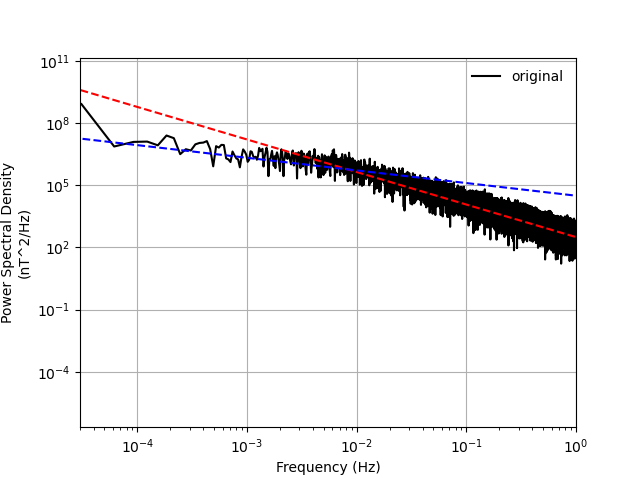

In [8]:
%matplotlib ipympl
plt.close()
ax1 = plt.subplot()

step = sig_ut.size
window = sig_ut.size
time, frequency, coef_bx, psd_bx, avg_bx = wfft_coef_psd(sig_ut, sig_bx, step = step, window = window)
ax1.plot(frequency, psd, 'k-', label = 'original')
# ax1.plot(frequency, psd_bx, 'k-', label = 'original')

# downsample = 10
# step = sig_ut[::downsample].size
# window = sig_ut[::downsample].size
# time, frequency, coef_bx, psd_bx, avg_bx = wfft_coef_psd(sig_ut[::downsample], sig_bx[::downsample], step = step, window = window)
# ax1.plot(frequency, psd_bx, 'r--', label = 'downsampled [N = 10]')

# frequency, psd_bx = scipy.signal.welch(sig_bx, fs = 1.0 / ((sig_ut[1] - sig_ut[0]).astype(float) / 1e9), nperseg = 2 ** 18)
# ax1.plot(frequency, psd_bx, 'b--', label = 'Welch')

ax1.legend(frameon = False)

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power Spectral Density\n(nT^2/Hz)')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlim(3e-5, 1e0)

ax1.grid('on')

f = np.geomspace(1e-5, 1e0, 1000)
ax1.plot(f, (10 ** 2.5) * f ** (-1.571), 'r--', lw = 1.5)
ax1.plot(f, (10 ** 4.5) * f ** (-.610), 'b--', lw = 1.5)
plt.show()

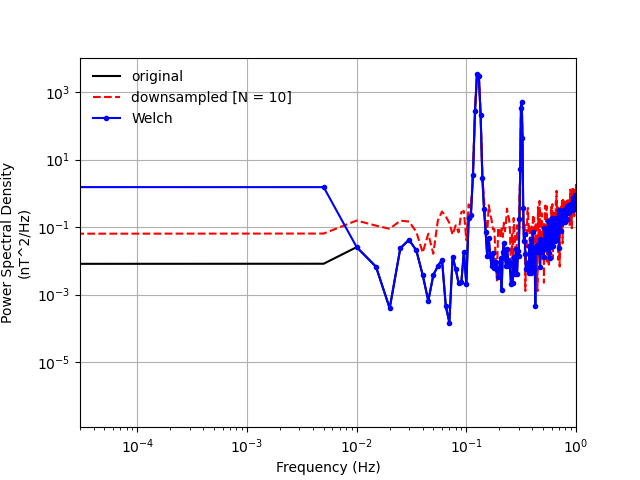

In [4]:

N = int(2 ** 15)

t = np.linspace(0, 200, N)
dt = t[1] - t[0]
fs = 1 / dt

omega = 0.4

# Generate a signal with 4 components: 
# 1. Sinuoidal; 2. Growing Sinuoidal; 3. Chirping Sinuoidal; 4. White noise

sig = 3 * np.sin(5 * omega * t) + 8 * t / 100 * np.sin(2 * omega * t) + 6 * np.sin(2 * omega * (t + 10) * t / 10)
sig += np.random.randn(sig.size) * 1e0

%matplotlib ipympl
plt.close()
ax1 = plt.subplot()

step = sig.size
window = sig.size
time, frequency, coef_bx, psd_bx, avg_bx = wfft_coef_psd(t, sig, step = step, window = window)
ax1.plot(frequency, psd_bx, 'k-', label = 'original')

downsample = 10
step = sig[::downsample].size
window = sig[::downsample].size
time, frequency, coef_bx, psd_bx, avg_bx = wfft_coef_psd(t[::downsample], sig[::downsample], step = step, window = window)
ax1.plot(frequency, psd_bx, 'r--', label = 'downsampled [N = 10]')

frequency, psd_bx = scipy.signal.welch(sig, fs = 1.0 / ((t[1] - t[0]).astype(float)), nperseg = 2 ** 15)
ax1.plot(frequency, psd_bx, 'b.-', label = 'Welch')

ax1.legend(frameon = False)

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Power Spectral Density\n(nT^2/Hz)')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlim(3e-5, 1e0)

ax1.grid('on')

# f = np.geomspace(1e-5, 1e0, 1000)
# ax1.plot(f, (10 ** 2.5) * f ** (-1.571), 'r--', lw = 1.5)
# ax1.plot(f, (10 ** 4.7) * f ** (-.610), 'b--', lw = 1.5)
plt.show()


In [ ]:
scipy.signal.morlet

<function scipy.signal._wavelets.cwt(data, wavelet, widths, dtype=None, **kwargs)>